## Process Optimization - the `Main` code 

### First Batch of Bayesian Optimization based on Experimental Data produced on Sep 22, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [1]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Load the experimental film data

In [2]:
########## Read in excel file ##########

# df_film = pd.read_excel('/Users/matt/Desktop/RAPID optimization/SL-PerovskiteOpt/ML_perovskite_data.xlsx', sheet_name='PVK Data')
df_film = pd.read_excel(
    "/groups/aprintz/github/SL-PerovskiteOpt/RAPID Optimization/ML_perovskite_data.xlsx",
    sheet_name="PVK Data",
)

df_film.columns = [
    "ML Condition",
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "volume used [uL]",
    "Confinement gap [um]",
    "% DMSO",
    "Temp Substrate [\N{DEGREE SIGN}C]",
    "Post Anneal time [m]",
    "Success or Fail",
    "Notes",
    "Where to find",
]
########## Get successful processing conditions ##########

success_conditions = df_film[df_film["Success or Fail"] == 1]["ML Condition"].values

########## Define processing variables to include ##########

included_vars = [
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "Confinement gap [um]",
    "% DMSO",
    "Temp Substrate [\N{DEGREE SIGN}C]",
    "Post Anneal time [m]",
]

########## Define new dataframe with only included processing variables ##########

df_included_vars = df_film[included_vars]
df_included_vars

Molarity [M]  Temperature [°C]  Speed [m/min]  Confinement gap [um]  \
0             0.4               100            1.0                   100   
1             0.4               100            0.5                   100   
2             0.4               100            1.0                   100   
3             0.4               100            0.5                   100   
4             0.4               100            1.0                   100   
..            ...               ...            ...                   ...   
103           1.2               100            0.5                   100   
104           1.2               100            1.0                   100   
105           1.2               100            0.5                   100   
106           1.2               100            1.0                   100   
107           1.2               100            0.5                   100   

     % DMSO  Temp Substrate [°C]  Post Anneal time [m]  
0        10                  150                     5  
1        10                  150                     5  
2        20                  150                     5  
3        20                  150                     5  
4        30                  150                     5  
..      ...                  ...                   ...  
103      40                  150                     5  
104      60                  150                     5  
105      60                  150                     5  
106      80                  150                     5  
107      80                  150                     5  

[108 rows x 7 columns]

# Set the variable space of process conditions

In [3]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

precursor_min, precursor_max, precursor_step = [
    0.4,
    2,
    0.2,
]  # Unit: concentration ## 4 steps
precursor_var = np.arange(precursor_min, precursor_max + precursor_step, precursor_step)
precursor_num = len(precursor_var)

super_temp_min, super_temp_max, super_temp_step = [
    50,
    200,
    5,
]  ## Unit: degC ## 30 steps
super_temp_var = np.arange(
    super_temp_min, super_temp_max + super_temp_step, super_temp_step
)
super_temp_num = len(super_temp_var)

speed_min, speed_max, speed_step = [0.5, 3, 0.5]  ## Unit: m/min ## 9 steps
speed_var = np.arange(speed_min, speed_max + speed_step, speed_step)
speed_num = len(speed_var)

dist_min, dist_max, dist_step = [25, 200, 5]  ## Unit: microns ## 7 steps
dist_var = np.arange(dist_min, dist_max + dist_step, dist_step)
dist_num = len(dist_var)

dmso_min, dmso_max, dmso_step = [0, 100, 5]  # Unit: %DMSO ## 3 steps
dmso_var = np.arange(dmso_min, dmso_max + dmso_step, dmso_step)
dmso_num = len(dmso_var)

sub_temp_min, sub_temp_max, sub_temp_step = [50, 200, 5]  ## Unit: degC ## 30 steps
sub_temp_var = np.arange(sub_temp_min, sub_temp_max + sub_temp_step, sub_temp_step)
sub_temp_num = len(sub_temp_var)

anneal_min, anneal_max, anneal_step = [0, 10, 2.5]  ## Unit: Minutes ## 5 steps
anneal_var = np.arange(anneal_min, anneal_max + anneal_step, anneal_step)
anneal_num = len(anneal_var)


########## Create process variable array ##########
var_array = [
    precursor_var,
    super_temp_var,
    speed_var,
    dist_var,
    dmso_var,
    sub_temp_var,
    anneal_var,
]

########## Create labels for process variable array, making sure order is same as var_array ##########
x_labels = [
    "Precursor Concentration [M]",
    "Superstrate Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "Working Distance [\N{greek small letter mu}m]",
    "DMSO Concentration [%v/v]",
    "Substrate Temperature [\N{DEGREE SIGN}C]" "Post Annealing Time [min]",
]


def x_normalizer(X):

    def max_min_scaler(x, x_max, x_min):
        return (x - x_min) / (x_max - x_min)

    x_norm = []
    for x in X:
        x_norm.append(
            [
                max_min_scaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_norm)


def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x * (x_max - x_min) + x_min

    x_original = []
    for x in x_norm:
        x_original.append(
            [
                max_min_rescaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_original)


def get_closest_array(suggested_x):

    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value: abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value

    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append(
            [get_closest_value(x[i], var_list[i]) for i in range(len(x))]
        )
    return np.array(modified_array)

### Define Emukit variable space from above processing conditions. Only edit if variables added/removed. Make sure the order and number of variables is consistent!

In [4]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign

parameter_space = ParameterSpace(
    [
        ContinuousParameter(
            "Precursor",
            0 - 1 / (precursor_num - 1) / 2,
            1 + 1 / (precursor_num - 1) / 2,
        ),
        ContinuousParameter(
            "SuperTemp",
            0 - 1 / (super_temp_num - 1) / 2,
            1 + 1 / (super_temp_num - 1) / 2,
        ),
        ContinuousParameter(
            "Speed", 
            0 - 1 / (speed_num - 1) / 2, 
            1 + 1 / (speed_num - 1) / 2
        ),
        ContinuousParameter(
            "Dist",
            0 - 1 / (dist_num - 1) / 2,
            1 + 1 / (dist_num - 1) / 2
        ),
        ContinuousParameter(
            "DMSO",
            0 - 1 / (dmso_num - 1) / 2,
            1 + 1 / (dmso_num - 1) / 2
        ),
        ContinuousParameter(
            "SubTemp",
            0 - 1 / (sub_temp_num - 1) / 2,
            1 + 1 / (sub_temp_num - 1) / 2
        ),
        ContinuousParameter(
            "Anneal",
            0 - 1 / (anneal_num - 1) / 2,
            1 + 1 / (anneal_num - 1) / 2
        ),
    ]
)

### Run GP Classification on the Experimental Data using GPy
- Experimental film data for round 0 initial sampling: binary film quality

In [5]:
from GPy.models import GPRegression, GPClassification
import GPyOpt

np.random.seed(10)  # Seed for reproducible randomization

x_init = x_normalizer(  # Normalize experimental data
    df_included_vars.to_numpy()
)  # for this line to pass, make sure that the number of colunmns (minus notes) in
# excel spreadsheet match the number of variables under "Set the variable space of process conditions" section of workbook

# Get array of pass/fail conditions
y_init = np.transpose([df_film["Success or Fail"].to_numpy()])

# Rename variables to statistics standard
X, Y = [x_init, y_init]

input_dim = len(X[0])  # Get number of variables in data


# Define the objective function to optimize using GPyOpt
def objective_function(hyperparameters):
    """Automatic Relevance Determination (ARD) kernel is a type of kernel function used in Gaussian
    Process Regression (GPR) that allows the model to automatically determine the relevance (importance)
    of each input feature (dimension) in predicting the output. The ARD kernel is particularly useful when
    you have high-dimensional input data and want the model to automatically select the most relevant features
    for prediction."""

    # Convert hyperparameters to the format expected by the model
    kernel = GPy.kern.RBF(
        input_dim=input_dim,
        variance=hyperparameters[0, 0],
        lengthscale=hyperparameters[0, 1:],
        ARD=True,
    )

    # Create the GP classifier
    model_gpy = GPClassification(X, Y, kernel=kernel)

    # # Optimize the model
    model_gpy.optimize()

    # Return the cross-validation score
    return -model_gpy.log_likelihood()


# Define the hyperparameter search space
hyperparameter_space = [
    {"name": "variance",
     "type": "continuous",
     "domain": (0.1, 5)
     },
    {
        "name": "lengthscale",
        "type": "continuous",
        "domain": (0.1, 100),
        "dimensionality": input_dim,  # set =1 if not using ARD kernel
    },
]

# Initialize the GPyOpt optimizer
optimizer = GPyOpt.methods.BayesianOptimization(
    f=objective_function, 
    domain=hyperparameter_space,
    acquisition_type='EI',
    acquisition_optimizer_type='lbfgs',
    model_update_interval=1,
    num_cores=16
    )


In [6]:
from emukit.model_wrappers import GPyModelWrapper

# Run the optimization
optimizer.run_optimization(max_iter=100)

# Get the best hyperparameters
best_hyperparameters = optimizer.x_opt
print("Best hyperparameters:", best_hyperparameters)
# Get the best hyperparameters
best_variance, *best_lengthscale = optimizer.x_opt

Best hyperparameters: [  5.           0.1          0.1          0.1         23.49215383
   0.1          0.1        100.        ]


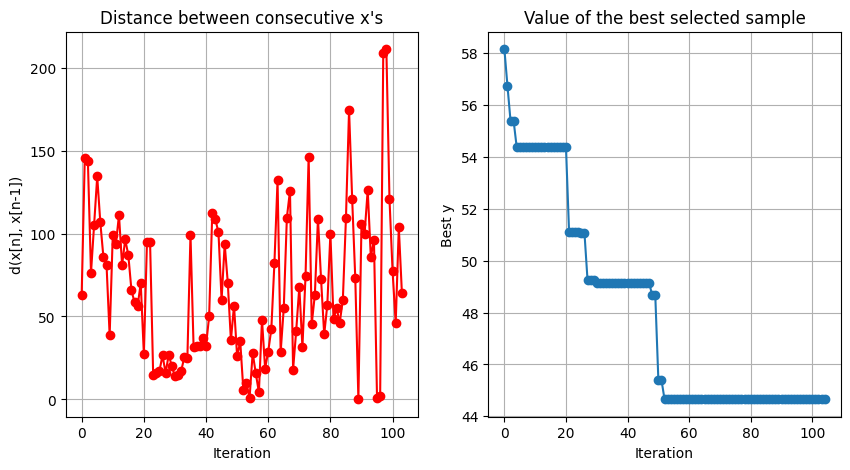

In [7]:
optimizer.plot_convergence()

### Construct objective function model from best variance and lengthscale(s)

In [8]:
from emukit.model_wrappers import GPyModelWrapper

# Create the kernel with the best hyperparameters
kernel = GPy.kern.RBF(
    input_dim=input_dim, 
    variance=best_variance,
    lengthscale=best_lengthscale,
    ARD=True
)

# Create the GP classifier with the best hyperparameters
model_gpy = GPy.models.GPClassification(X, Y, kernel=kernel)

# # Optimize using Gpy
# kernel.lengthscale.constrain_bounded(0.1, 1) #upper bound set to 1
# kernel.variance.constrain_bounded(0.1, 1000.0)
# model_gpy.randomize()
# model_gpy.optimize_restarts(num_restarts=100,verbose =False, messages=False)
# model_gpy.optimize()

objective_model = GPyModelWrapper(model_gpy)

### Visualize variable index (columms in order from excel) vs. lengthscale

In [9]:
objective_model.model.kern.lengthscale

gp_classification.rbf.lengthscale:
Param([  0.1       ,   0.1       ,   0.1       ,  23.49215383,
         0.1       ,   0.1       , 100.        ])

### Predict binary success/fail using trained classifier

108 108 108 108
108 108
108 108


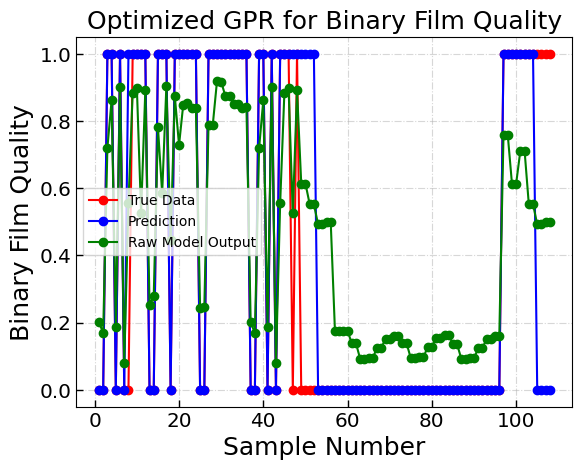

In [10]:
from sklearn.metrics import mean_squared_error

print(len(x_init), len(X), len(y_init), len(Y))
print(len(model_gpy.X), len(model_gpy.Y))
print(len(objective_model.X), len(objective_model.Y))

y_pred, y_uncer = objective_model.predict(X)

y_pred = y_pred[:, -1]  # transpose
# y_uncer = np.sqrt(y_uncer[:, -1])

# Convert probabilities to binary predictions since model outputs contineous data in the space [0,1]

threshold = 0.5  # Above threshold, pass. Below threshold, fail.
y_pred_binary = (y_pred > threshold).astype(int)

fontsize = 18
lims = (-0.1, 1.1)

# Plot the true input data and the prediction against the data point number
plt.figure(dpi=100)
plt.plot(range(1, len(Y) + 1), Y[:, -1], "ro-", label="True Data")
plt.plot(range(1, len(Y) + 1), y_pred_binary, "bo-", label="Prediction")
plt.plot(range(1, len(Y) + 1), y_pred, "go-", label="Raw Model Output")

title = "Optimized GPR for Binary Film Quality"
plt.xlabel("Sample Number", fontsize=fontsize)
plt.ylabel("Binary Film Quality", fontsize=fontsize)
plt.title(title, fontsize=fontsize)
plt.legend()
plt.tick_params(
    direction="in", length=5, width=1, labelsize=fontsize * 0.8, grid_alpha=0.5
)
plt.grid(True, linestyle="-.")

### Get classification statistics using sklearn / scipy

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

mse = mean_squared_error
mse_all = mse(Y[:, -1], y_pred)
print("all rmse: %.4f" % (np.sqrt(mse_all)))

rsquared_all = r2_score(Y[:, -1], y_pred)
print("all R^2: %.4f" % (rsquared_all))

sprman_all = spearmanr(Y[:, -1], y_pred)
print("all spearman: %.4f" % (sprman_all[0]))


all rmse: 0.2670
all R^2: 0.7066
all spearman: 0.8227


# Bayesian Optimization 

### Select acquisition function

In [12]:
from emukit.experimental_design.acquisitions import (
    ModelVariance,
    IntegratedVarianceReduction,
)
from emukit.bayesian_optimization.acquisitions import (
    ExpectedImprovement,
    NegativeLowerConfidenceBound,
)
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

acquisition_function = ModelVariance(model=objective_model)
# acquisition_function = ExpectedImprovement(model=objective_model)
# acquisition_function = NegativeLowerConfidenceBound(model=objective_model, beta=1)
# acquisition_function = ExpectedImprovement(model=objective_model)

### Use GPyOpt to perform bayesian optimization on GPy model and extract new test conditions
https://nbviewer.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_external_objective_evaluation.ipynb


In [14]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from scipy.stats import entropy
from emukit.bayesian_optimization.local_penalization_calculator import LocalPenalizationPointCalculator
# objective_model = GPyModelWrapper(model_gpy)

def objective_function(x):
    # print(x)
    pred, _ = model_gpy.predict(np.array(x))
    # model_gpy.log_likelihood()
    return -entropy(pred)

# bo = GPBayesianOptimization(variables_list=parameter_space, X=X, Y=Y)


# bo.run_optimization(objective_function, 10)
    
num_new_samples = 10
# Initialize the GPyOpt optimizer


expdesign_loop = ExperimentalDesignLoop(
    model=objective_model,
    space=parameter_space,
    acquisition=acquisition_function,
    batch_size=num_new_samples,
    update_interval=1,
)

# expdesign_loop.run_loop(objective_function, stopping_condition=10)
# Run the optimization loop for a certain number of iterations
X_new = expdesign_loop.candidate_point_calculator.compute_next_points(expdesign_loop.loop_state)

# # Get the new data points suggested by the optimizer for testing in the lab

# print(new_X)

# X_new = expdesign_loop.candidate_point_calculator.compute_next_points(loop_state)
# # # X_new = x_normalizer(get_closest_array(x_denormalizer(X_new)))

TypeError: 'float' object is not subscriptable

### Create Emukit experimental design loop

In [ ]:

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(
    model_objective=objective_model,
    space=parameter_space,
    acquisition=acquisition,
    model_constraint1=constraint_model1,
    #   model_constraint2=constraint_model2,
    batch_size=22,
)  # batchsize>20 to account for duplication

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(
    bayesopt_cons_pr.loop_state
)
X_new = x_normalizer(get_closest_array(x_denormalizer(X_new)))

f_obj = objective_model.model.predict
f_cons1 = constraint_model1.model.predict
# f_cons2 = constraint_model2.model.predict

f_cons_acq = (
    bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
)
f_raw_acq = (
    bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
)
# f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print("total condition no.:", len(Xc))
print("total device no.:", len(bayesopt_cons_pr.loop_state.Y))
print(
    "maximum Y (PCE [%]): ",
    -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))),
)

df_Xnew = pd.DataFrame(
    get_closest_array(x_denormalizer(X_new)), columns=df_film.columns[1:7]
)
df_all = pd.concat(
    [df_film.iloc[:, 1:7], df_Xnew]
)  # .sort_values(by=list(df_film.columns[1:7]))
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[20:40]
df_Xnew = df_Xnew.sort_values(by=list(df_film.columns[1:7]), ignore_index=True)
df_Xnew.index = np.arange(len(df_Xnew)) + len(df_film)
df_Xnew

NameError: name 'ProbabilisticConstraintBayesianOptimizationLoop2' is not defined

#### Quick histogram visualization of the newly suggested process conditions

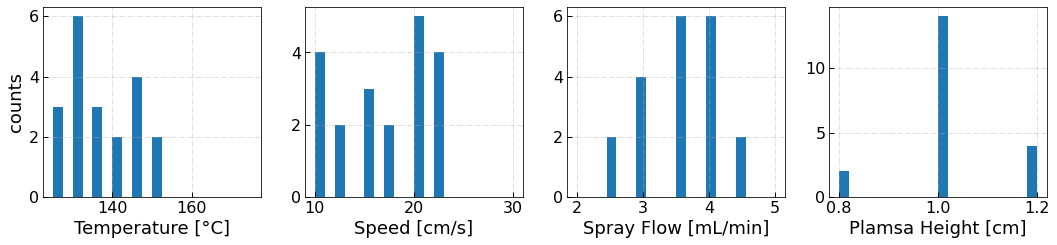

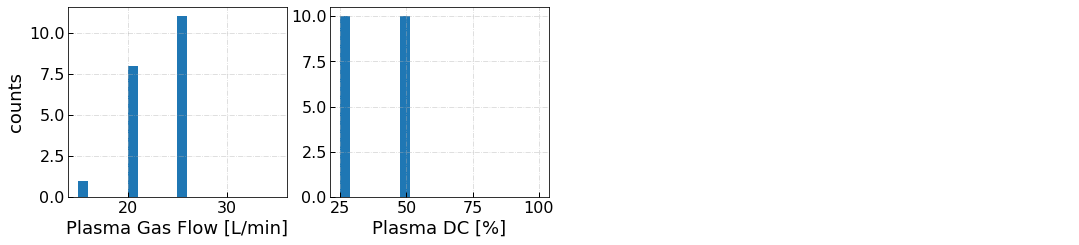

In [ ]:
df = df_Xnew
df_cols = df.columns
n_col = 4  # num of columns per row in the figure

for n in np.arange(0, 8, n_col):
    fig, axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey=False)
    fontsize = 20
    for i in np.arange(n_col):
        if n < len(df_cols):
            axes[i].hist(
                df.iloc[:, n], bins=20, range=(min(var_array[n]), max(var_array[n]))
            )  ####
            axes[i].set_xlabel(df_cols[n], fontsize=18)
            # axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
        else:
            axes[i].axis("off")
        n = n + 1
    axes[0].set_ylabel("counts", fontsize=18)
    for i in range(len(axes)):
        axes[i].tick_params(
            direction="in", length=5, width=1, labelsize=fontsize * 0.8, grid_alpha=0.5
        )
        axes[i].grid(True, linestyle="-.")
    plt.show()

#### Visualisation of Efficiency vs ML conditions, and Acquisition

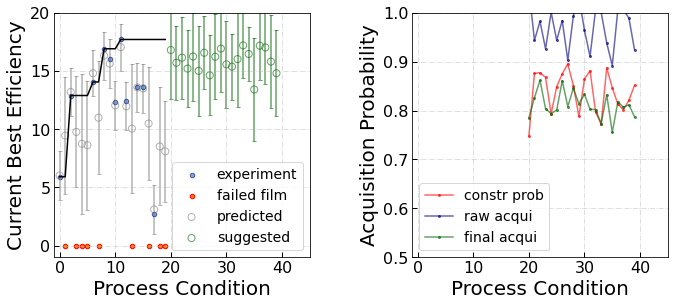

In [ ]:
f_obj = objective_model.model.predict

device_eff = df_device.sort_values("ML Condition").iloc[:, [0, -1]].values
film_quality = df_film.sort_values("ML Condition").iloc[:, [0, -2]].values

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey=False)
fontsize = 20
exp_cond = np.transpose(device_eff)[0]
exp_eff = np.transpose(device_eff)[1]

axes[0].scatter(
    exp_cond,
    exp_eff,  # facecolor = 'none',
    edgecolor="navy",
    s=20,
    alpha=0.6,
    label="experiment",
)

unsuccess_film = np.transpose(film_quality[film_quality[:, -1] == 0])
axes[0].scatter(
    unsuccess_film[0],
    unsuccess_film[1],
    # facecolor = 'none',
    edgecolor="red",
    s=20,
    label="failed film",
)
all_cond = np.concatenate([device_eff, np.transpose(unsuccess_film)])
all_cond = all_cond[np.argsort(all_cond[:, 0])]
axes[0].plot(
    np.transpose(all_cond)[0],
    np.maximum.accumulate(np.transpose(all_cond)[1]),
    marker="o",
    ms=0,
    c="black",
)

X_sorted = x_normalizer(df_film.sort_values("ML Condition").iloc[:, 1:7].values)
y_pred, y_uncer = f_obj(X_sorted)
y_pred = -y_pred[:, -1]
y_uncer = np.sqrt(y_uncer[:, -1])

axes[0].scatter(
    np.arange(len(X_sorted)),
    y_pred,
    s=50,
    facecolors="none",
    alpha=0.6,
    edgecolor="gray",
    label="predicted",
)
axes[0].errorbar(
    np.arange(len(X_sorted)),
    y_pred,
    yerr=y_uncer,
    ms=0,
    ls="",
    capsize=2,
    alpha=0.6,
    color="gray",
    zorder=0,
)


y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new[:, -1]
y_uncer_new = np.sqrt(y_uncer_new[:, -1])

axes[0].scatter(
    np.arange(len(X_new)) + len(Xc),
    y_pred_new,
    s=50,
    facecolors="none",
    alpha=0.6,
    edgecolor="darkgreen",
    label="suggested",
)
axes[0].errorbar(
    np.arange(len(X_new)) + len(Xc),
    y_pred_new,
    yerr=y_uncer_new,
    ms=0,
    ls="",
    capsize=2,
    alpha=0.6,
    color="darkgreen",
    zorder=0,
)


axes[0].set_ylabel("Current Best Efficiency", fontsize=20)
axes[0].set_xlabel("Process Condition", fontsize=20)

axes[0].set_ylim(-1, 20)
axes[0].set_xlim(-1, 45)
axes[0].set_xticks(np.arange(0, 41, 10))
axes[0].legend(fontsize=fontsize * 0.7)

axes[1].plot(
    np.arange(len(X_new)) + len(Xc),
    acq_cons,
    marker="o",
    ms=2,
    alpha=0.6,
    color="red",
    label="constr prob",
)
axes[1].plot(
    np.arange(len(X_new)) + len(Xc),
    acq_fcn / 20,
    marker="o",
    ms=2,
    alpha=0.6,
    color="navy",
    label="raw acqui",
)

axes[1].plot(
    np.arange(len(X_new)) + len(Xc),
    acq_produc / 20,
    marker="o",
    ms=2,
    alpha=0.6,
    color="darkgreen",
    label="final acqui",
)


axes[1].set_ylim(0.5, 1)
axes[1].set_xlim(-1, 45)
axes[1].set_xticks(np.arange(0, 45, 10))
axes[1].set_ylabel("Acquisition Probability", fontsize=fontsize)
axes[1].set_xlabel("Process Condition", fontsize=fontsize)

for ax in axes:
    ax.tick_params(
        direction="in", length=5, width=1, labelsize=fontsize * 0.8, grid_alpha=0.5
    )
    ax.grid(True, linestyle="-.")
plt.subplots_adjust(wspace=0.4)
plt.legend(fontsize=fontsize * 0.7)
plt.show()

### Visualize the Manifold of the Trained Models

##### Device Efficiency based on IV Measurement Data (after Pre-screened by Visual Inspection)
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

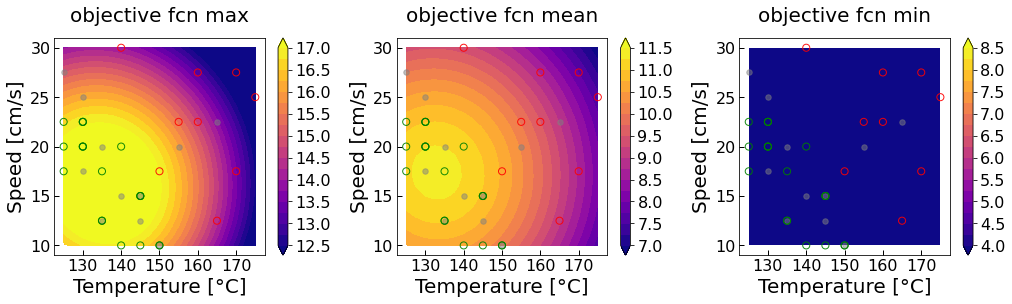

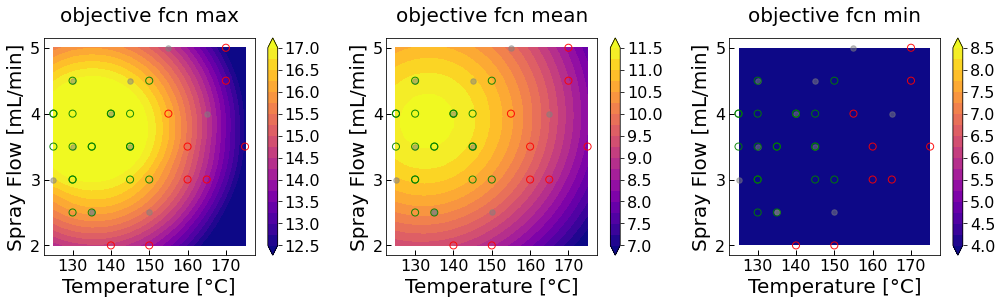

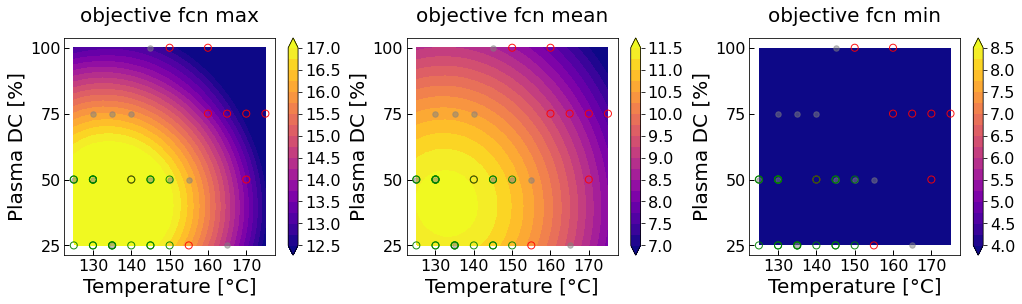

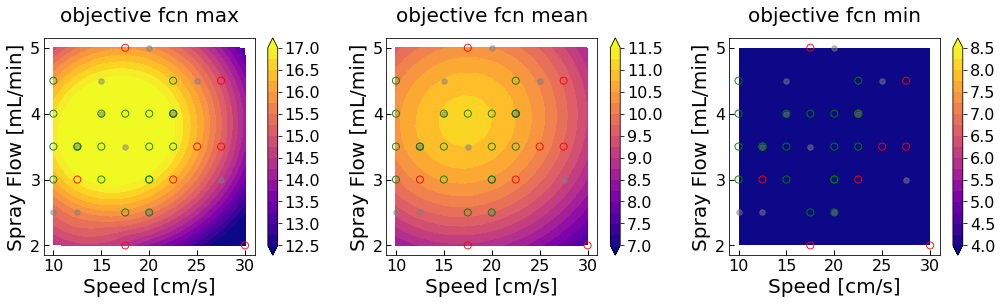

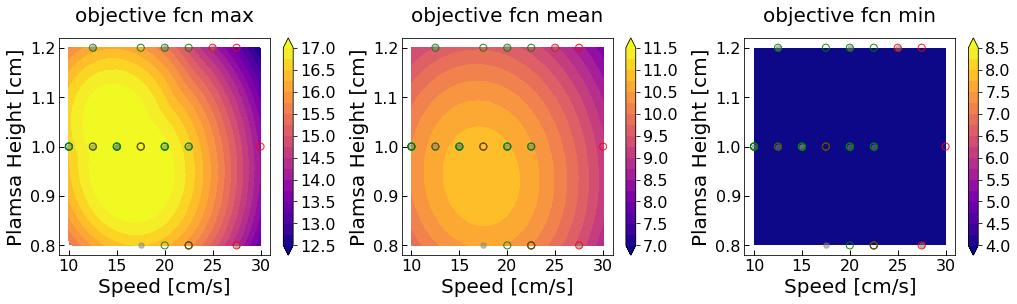

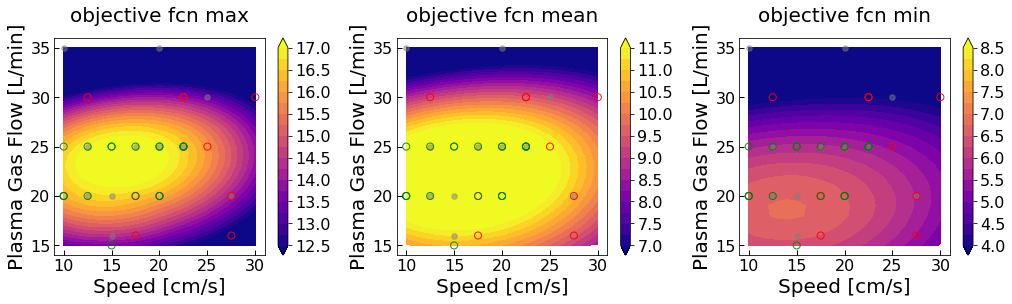

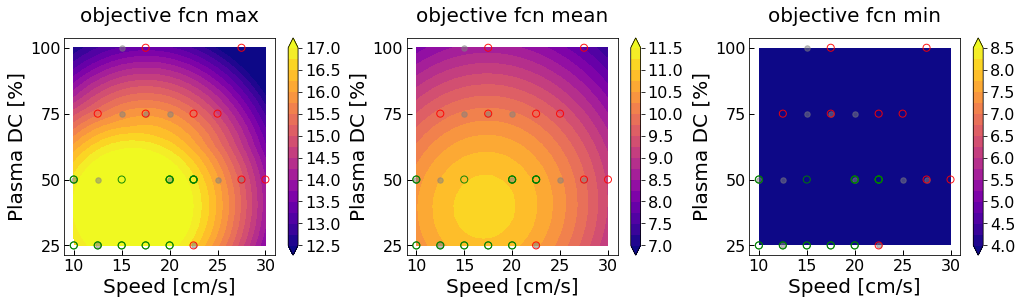

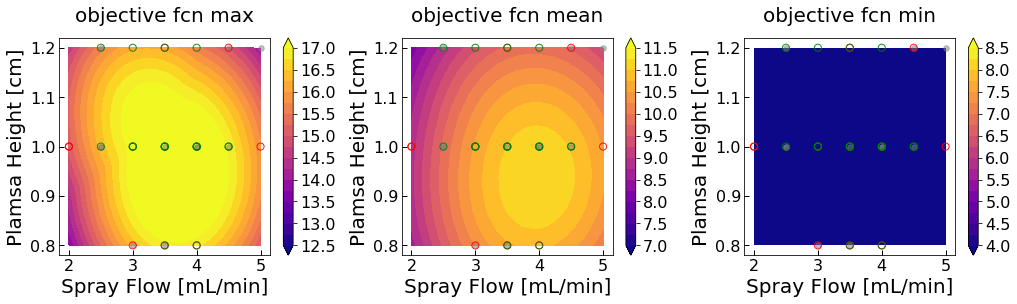

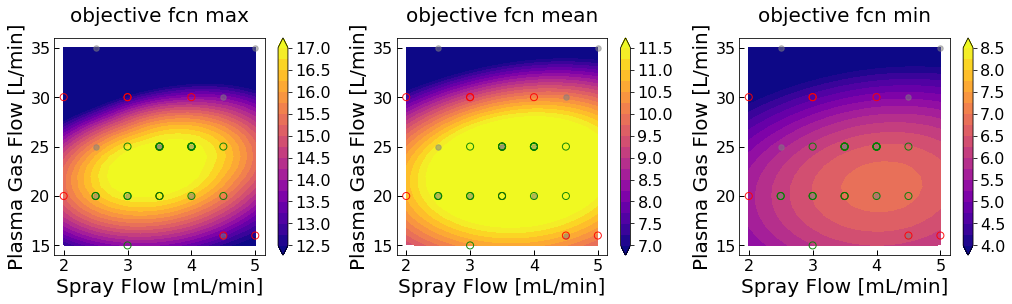

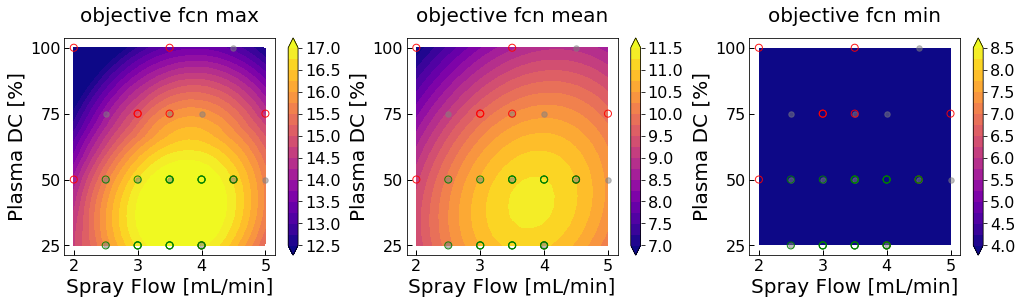

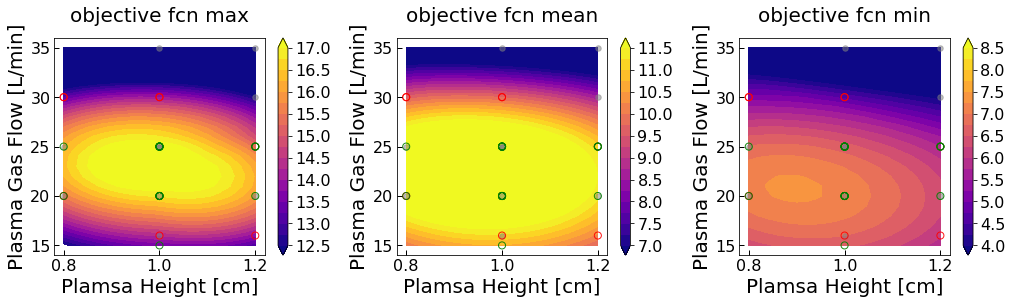

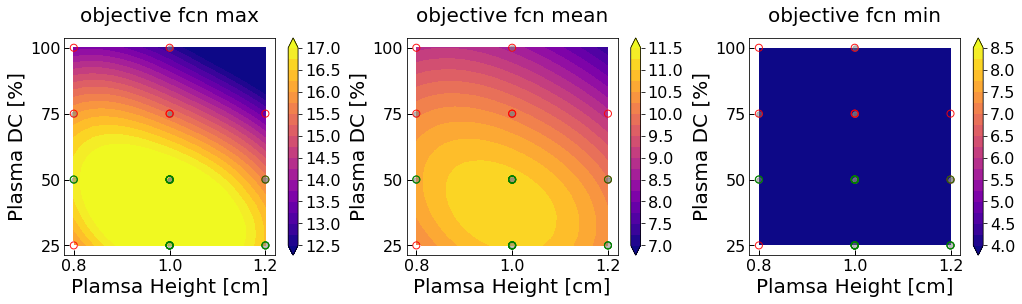

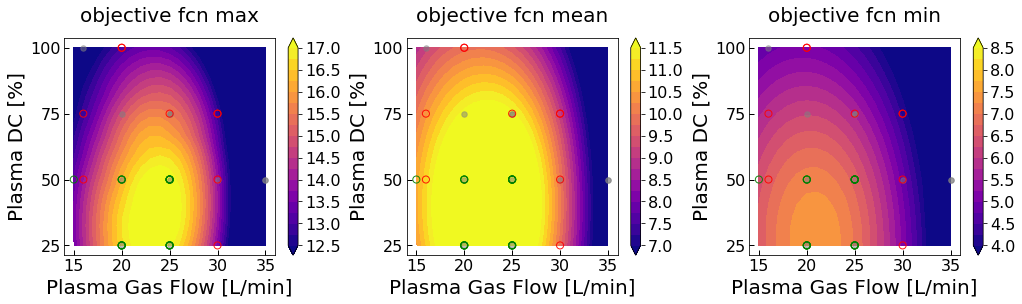

In [ ]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_device.iloc[:, 2:8].columns
for i in range(input_dim):
    for j in range(input_dim - i - 1):

        ## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j + i + 1
        n_steps = 21
        x1x2y_pred, x1x2y_uncer = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                y_pred, y_uncer = f_obj(x_temp)
                y_pred = -y_pred
                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)]
                )
                x1x2y_uncer.append(
                    [
                        x1_org,
                        x2_org,
                        np.max(np.sqrt(y_uncer)),
                        np.mean(np.sqrt(y_uncer)),
                        np.min(np.sqrt(y_uncer)),
                    ]
                )

        x1 = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)

        y_pred_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:, 2].reshape(
            n_steps, n_steps
        )
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:, 3].reshape(
            n_steps, n_steps
        )
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:, 4].reshape(
            n_steps, n_steps
        )

        fontsize = 20
        title_pad = 16

        ## Contour for Prediction Efficiency Mean
        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        colorbar_offset = [12.5, 7, 4]
        for ax, c_offset, y in zip(
            axes, colorbar_offset, [y_pred_max, y_pred_mean, y_pred_min]
        ):

            c_plt1 = ax.contourf(
                x1,
                x2,
                y,
                levels=np.arange(19) * 0.25 + c_offset,
                cmap="plasma",
                extend="both",
            )
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)
            ax.scatter(
                x_denormalizer(X)[:, ind1],
                x_denormalizer(X)[:, ind2],
                s=30,
                facecolors="gray",
                alpha=0.5,
                edgecolor="gray",
            )
            ax.scatter(
                x_denormalizer(Xc[Yc[:, -1] == 0])[
                    :, ind1
                ],  ## show the conditions with poor film quality
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="red",
            )

            ax.scatter(
                x_denormalizer(X_new)[:, ind1],
                x_denormalizer(X_new)[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="green",
            )
            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1) - np.min(x1)) * 0.05
            x2_delta = (np.max(x2) - np.min(x2)) * 0.05
            ax.set_xlim(np.min(x1) - x1_delta, np.max(x1) + x1_delta)
            ax.set_ylim(np.min(x2) - x2_delta, np.max(x2) + x2_delta)
            ax.tick_params(
                direction="in", length=5, width=1, labelsize=fontsize * 0.8
            )  # , grid_alpha = 0.5
            if ind1 == 0:  # Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1 == 1:  # Speed
                ax.set_xticks([10, 15, 20, 25, 30])
            if ind1 == 4:  # PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2 == 5:  # PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            # ax.grid(True, linestyle='-.')

        axes[0].set_title("objective fcn max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("objective fcn mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("objective fcn min", pad=title_pad, fontsize=fontsize)

        plt.subplots_adjust(wspace=0.3)
        plt.show()
        # # Contour for Uncertainty
        #         fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        #         colorbar_offset = [3, 2.5, 2]
        #         for ax, c_offset, y in zip(axes, colorbar_offset,
        #                                    [y_uncer_max, y_uncer_mean, y_uncer_min]):

        #             c_plt1 = ax.contourf(x1, x2, y,  levels = np.arange(11)*0.2+c_offset, cmap='plasma', extend = 'both')
        #             fig.colorbar(c_plt1, ax= ax)
        #             ax.scatter(x_denormalizer(X)[:, ind1],
        #                        x_denormalizer(X)[:, ind2],
        #                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'gray')
        #             ax.set_xlabel(str(x_columns[ind1]))
        #             ax.set_ylabel(str(x_columns[ind2]))

        #             x1_delta = (np.max(x1)-np.min(x1))*0.05
        #             x2_delta = (np.max(x2)-np.min(x2))*0.05
        #             ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
        #             ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)

        #         axes[0].set_title('objective uncer max', pad = title_pad)
        #         axes[1].set_title('objective uncer mean', pad = title_pad)
        #         axes[2].set_title('objective uncer min', pad = title_pad)
        #         plt.subplots_adjust(wspace = 0.25)
        plt.show()

##### Constraint Probablity based Visual Inspection Data of Film Quality 
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

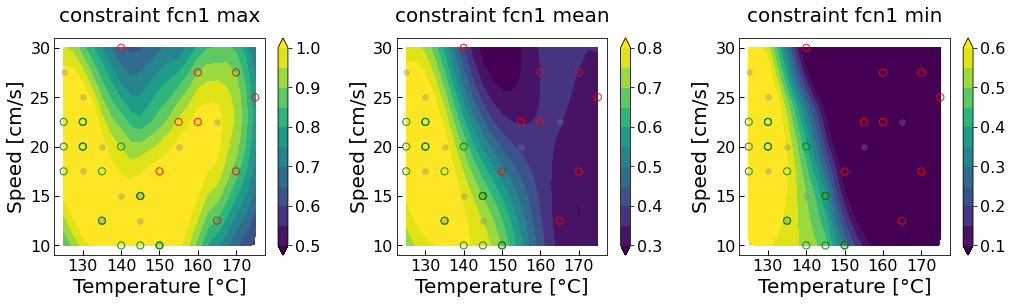

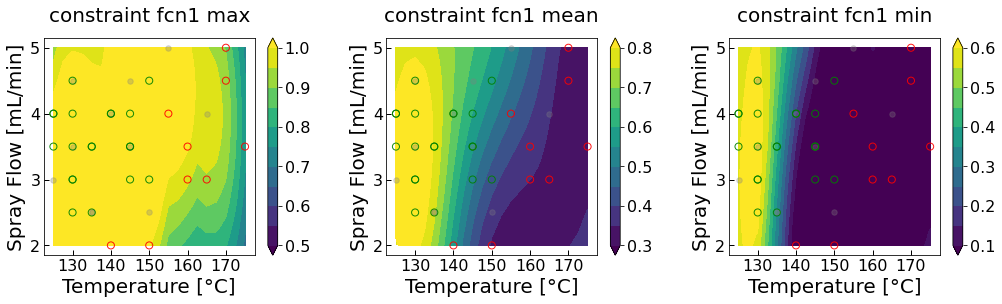

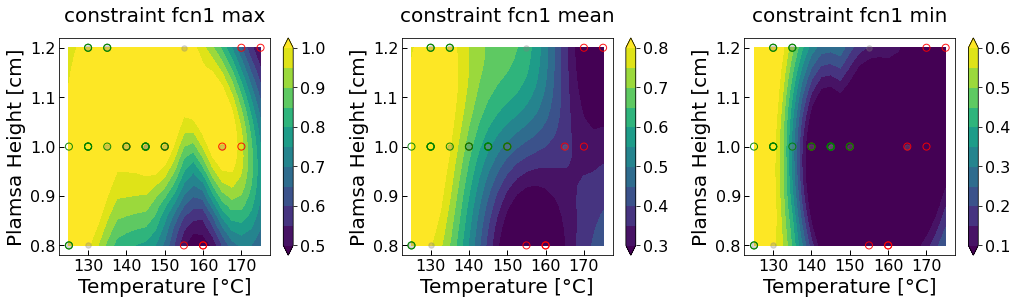

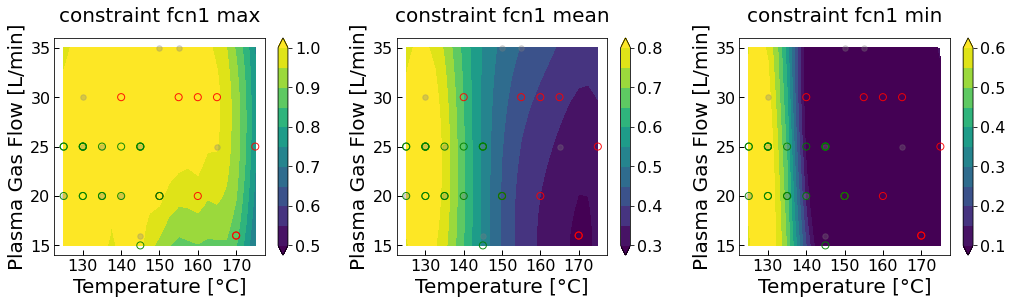

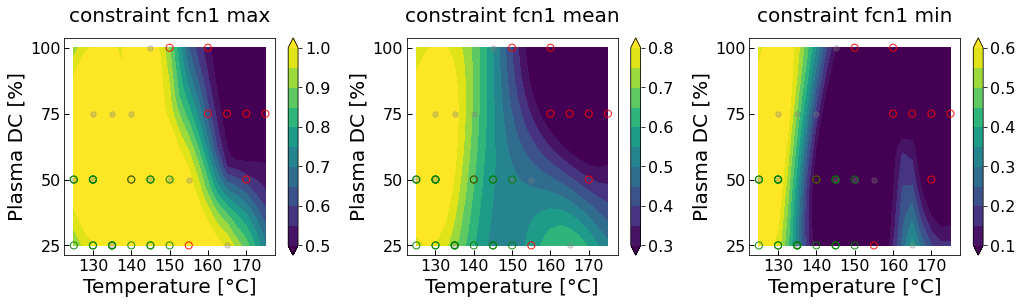

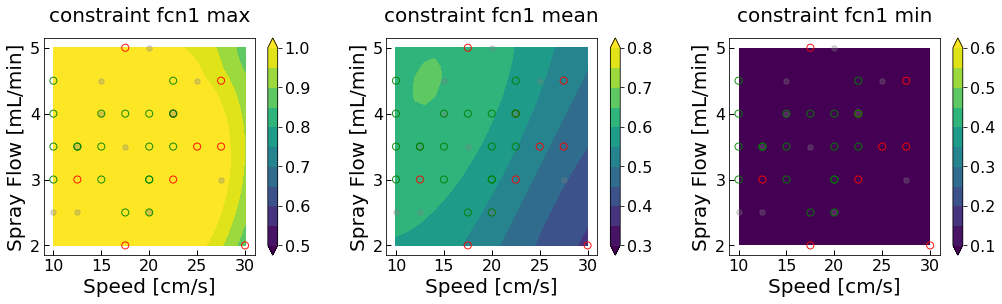

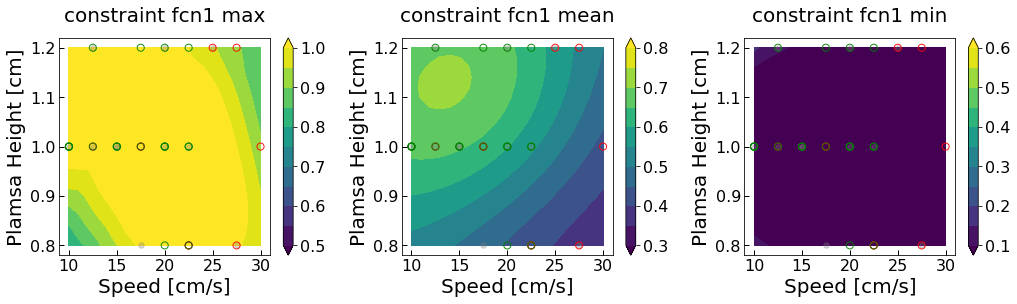

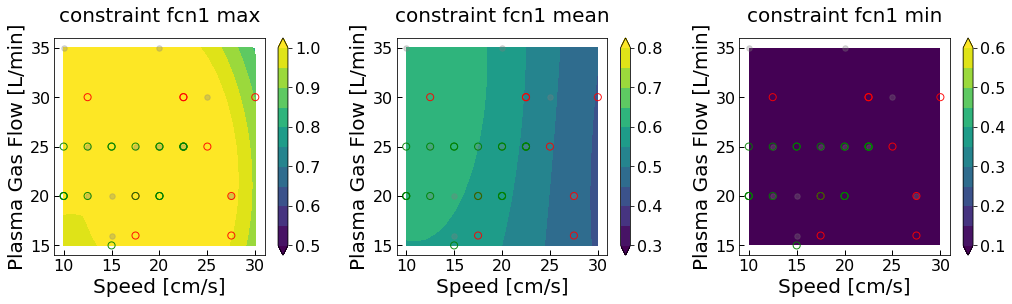

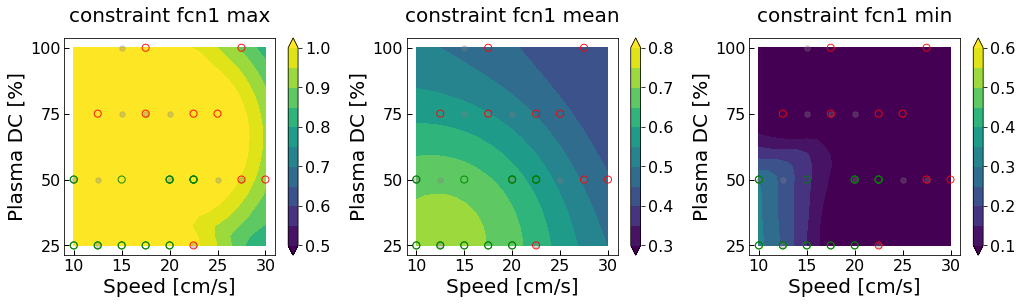

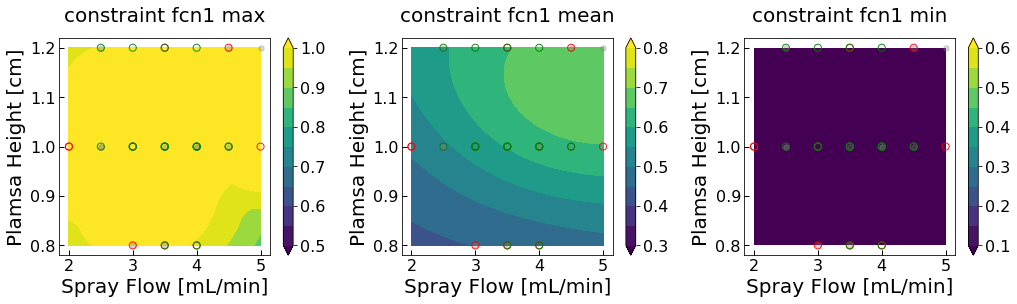

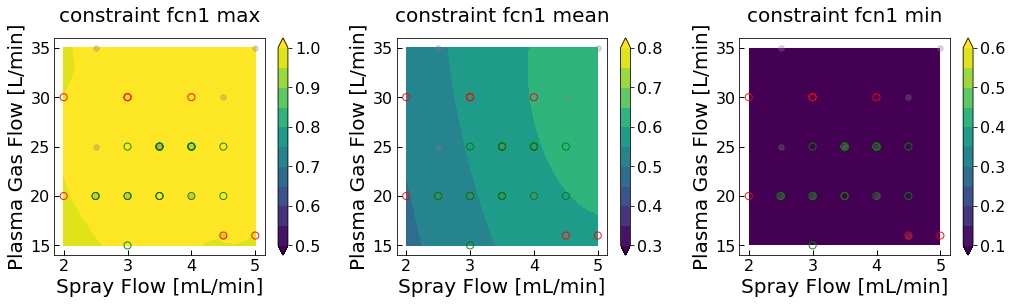

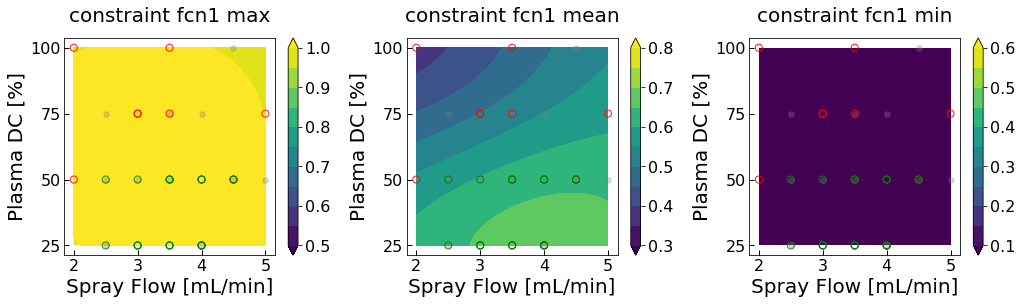

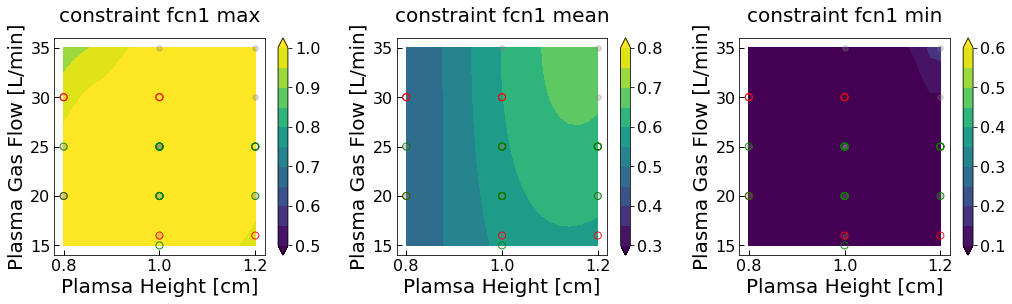

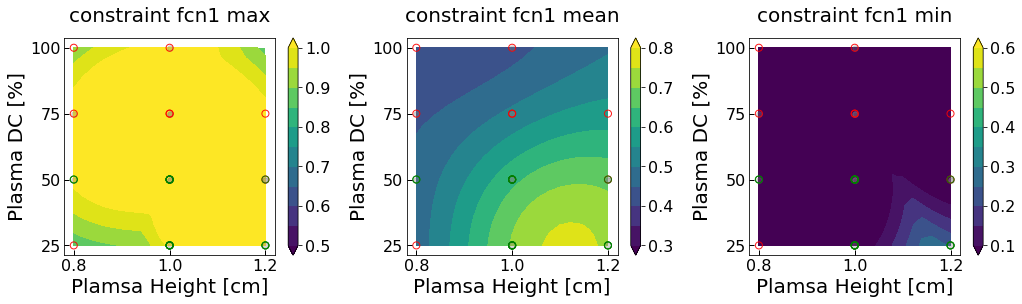

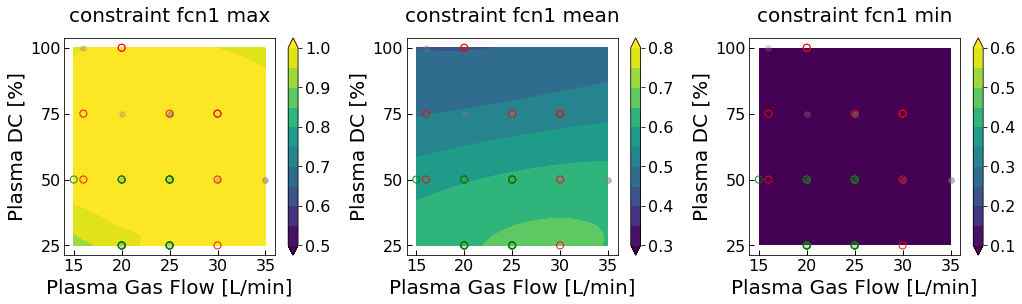

In [ ]:
np.random.seed(10)
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:, 1:-2].columns
for i in range(input_dim):
    for j in range(input_dim - i - 1):
        ind1 = i
        ind2 = j + i + 1
        n_steps = 21
        x1x2y_pred, x1x2y_var = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                yc_pr, yc_var = f_cons1(x_temp)
                yc_pr = -yc_pr + yc_offset
                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)]
                )

        x1c = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

        fontsize = 20
        title_pad = 16

        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        colorbar_offset = [0.5, 0.3, 0.1]
        for ax, y, c_offset in zip(
            axes, [yc_pr_max, yc_pr_mean, yc_pr_min], colorbar_offset
        ):
            c_plt1 = ax.contourf(
                x1c,
                x2c,
                y,
                levels=np.arange(11) * 0.05 + c_offset,
                cmap="viridis",
                extend="both",
            )  ## viridis
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)
            ax.scatter(
                x_denormalizer(X)[:, ind1],
                x_denormalizer(X)[:, ind2],
                s=30,
                facecolors="gray",
                alpha=0.3,
                edgecolor="gray",
            )
            ax.scatter(
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind1],
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="red",
            )
            ax.scatter(
                x_denormalizer(X_new)[:, ind1],
                x_denormalizer(X_new)[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="green",
            )

            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1c) - np.min(x1c)) * 0.05
            x2_delta = (np.max(x2c) - np.min(x2c)) * 0.05
            ax.set_xlim(np.min(x1c) - x1_delta, np.max(x1c) + x1_delta)
            ax.set_ylim(np.min(x2c) - x2_delta, np.max(x2c) + x2_delta)
            ax.tick_params(
                direction="in",
                length=5,
                width=1,
                labelsize=fontsize * 0.8,
                grid_alpha=0.5,
            )
            # ax.grid(True, linestyle='-.')

            if ind1 == 0:  # Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1 == 1:  # Speed
                ax.set_xticks([10, 15, 20, 25, 30])
            if ind1 == 4:  # PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2 == 5:  # PlasmaDC
                ax.set_yticks([25, 50, 75, 100])

        axes[0].set_title("constraint fcn1 max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("constraint fcn1 mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("constraint fcn1 min", pad=title_pad, fontsize=fontsize)
        plt.subplots_adjust(wspace=0.3)
        plt.show()

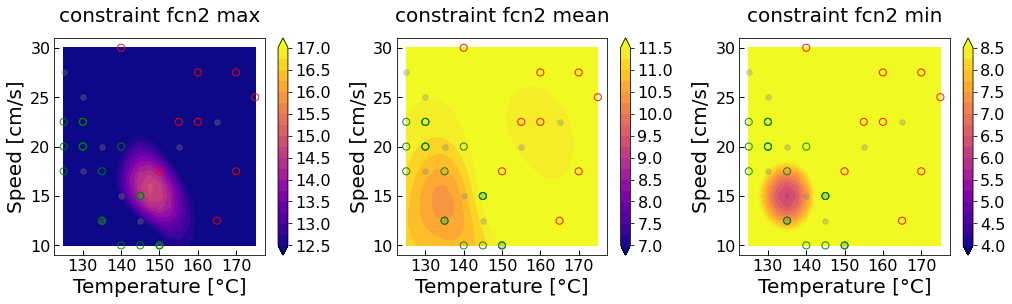

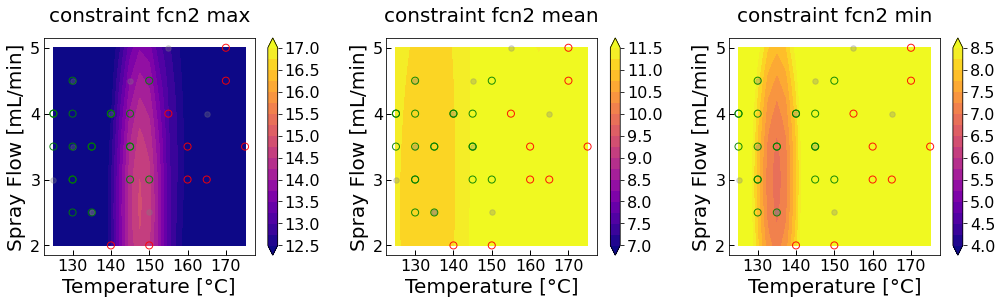

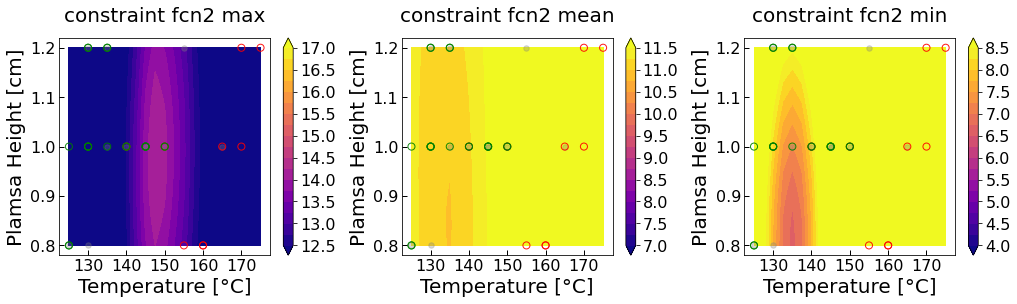

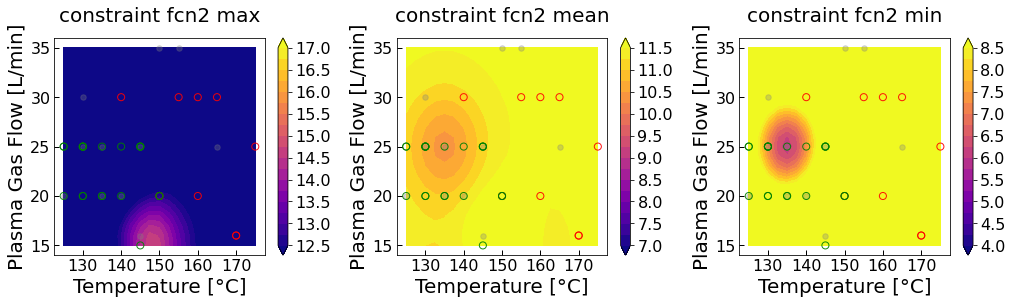

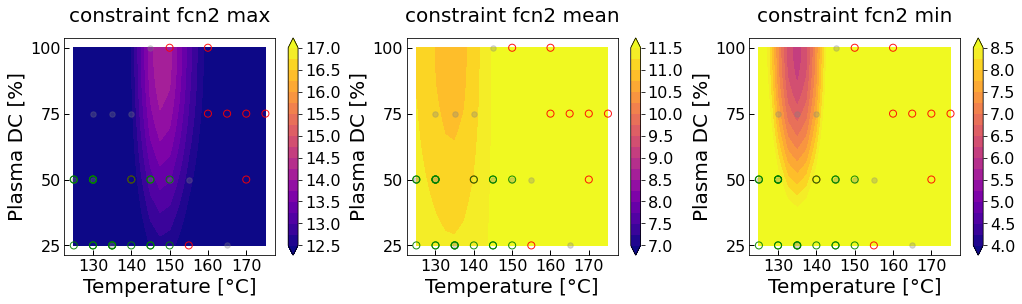

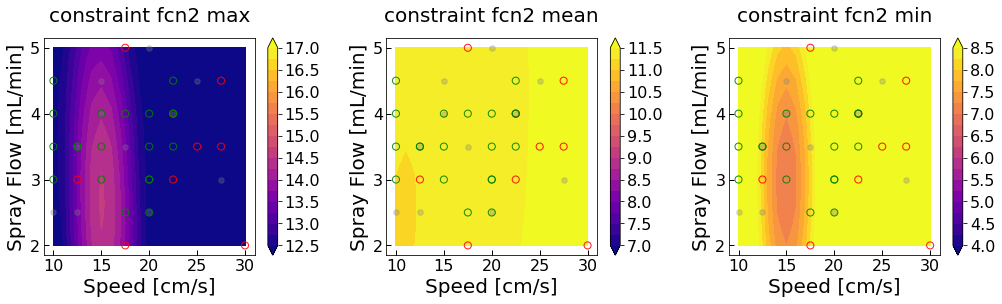

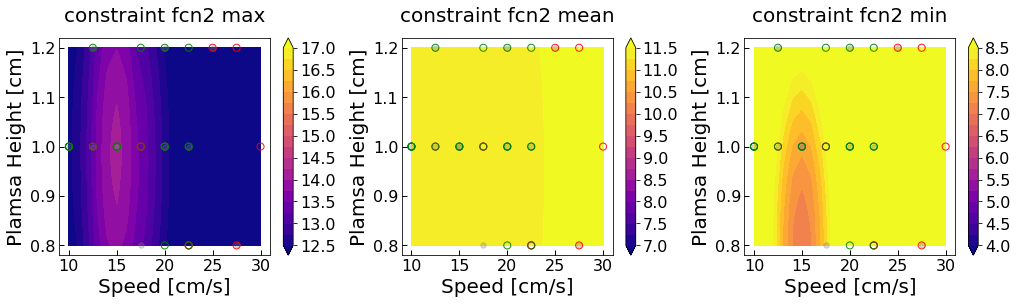

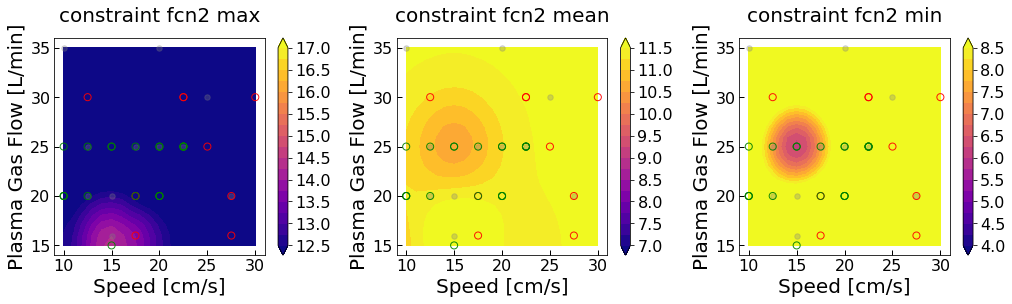

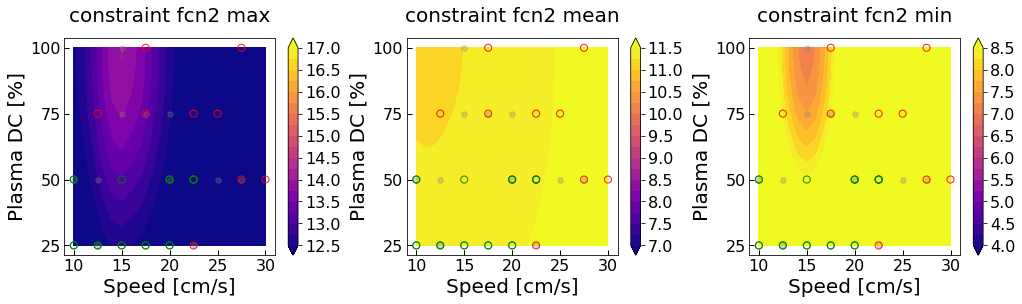

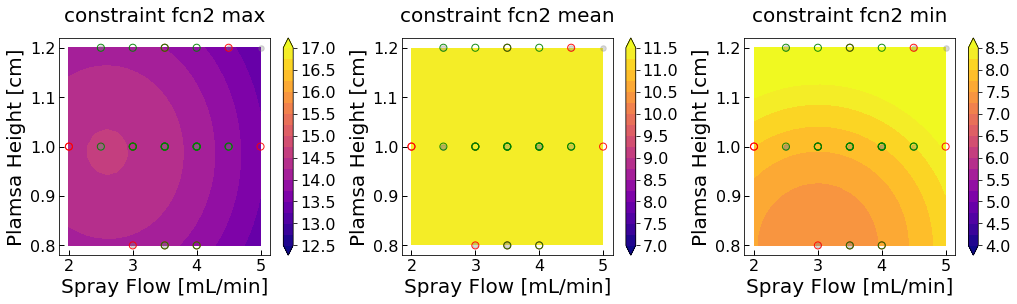

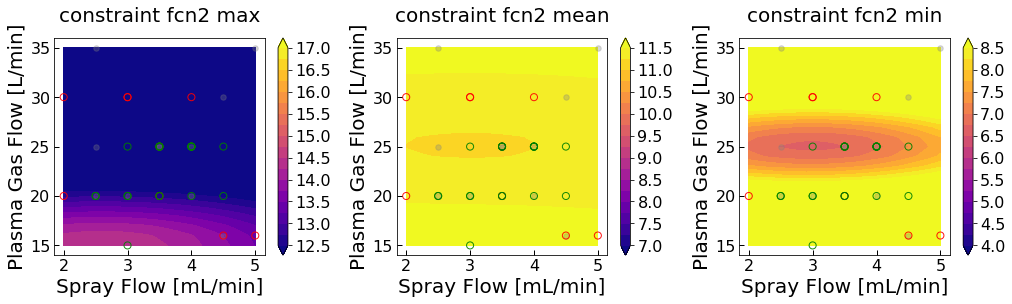

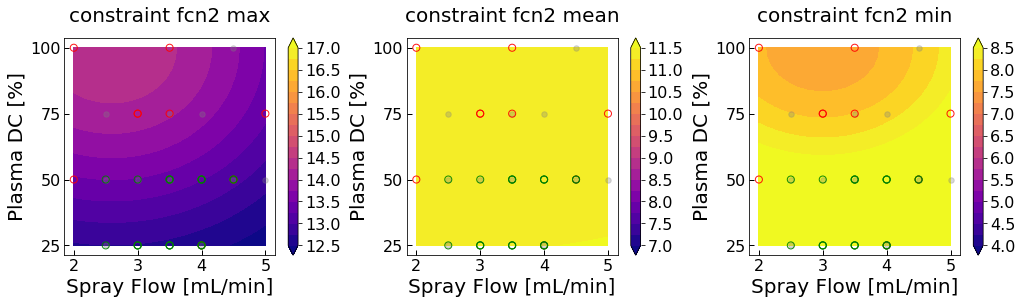

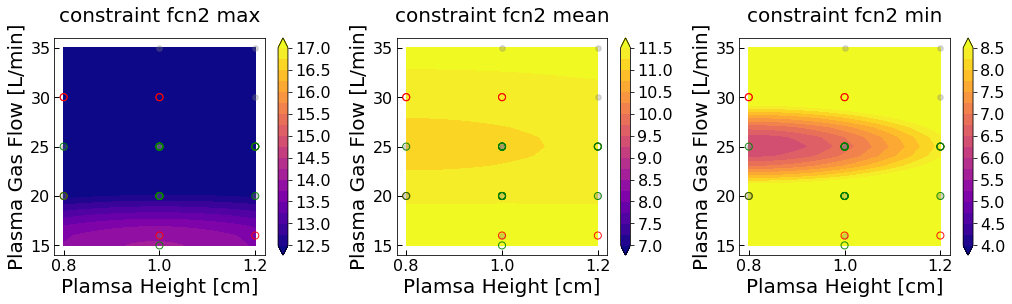

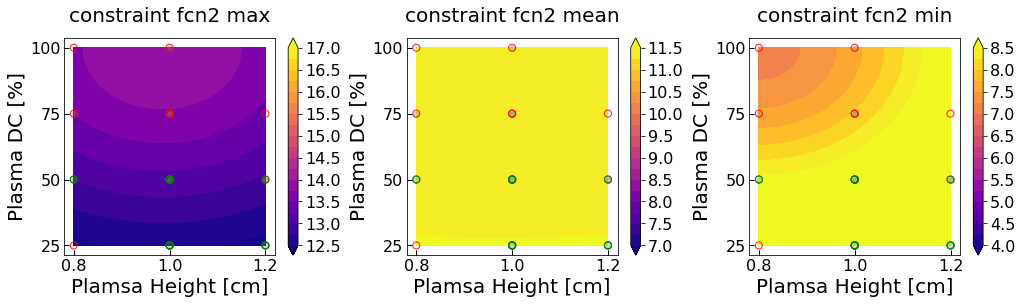

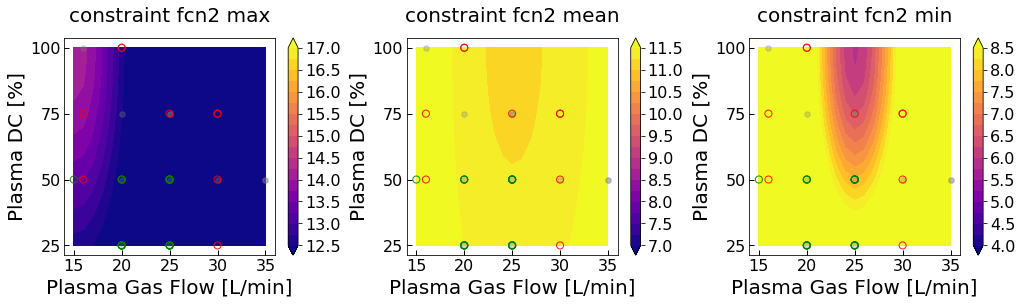

In [ ]:
np.random.seed(10)
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:, 1:-2].columns
for i in range(input_dim):
    for j in range(input_dim - i - 1):
        ind1 = i
        ind2 = j + i + 1
        n_steps = 21
        x1x2y_pred, x1x2y_var = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                yc_pr, yc_var = f_cons2(x_temp)
                yc_pr = -yc_pr + yc2_offset
                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)]
                )

        x1c = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

        fontsize = 20
        title_pad = 16

        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        colorbar_offset = [12.5, 7, 4]
        for ax, y, c_offset in zip(
            axes, [yc_pr_max, yc_pr_mean, yc_pr_min], colorbar_offset
        ):
            c_plt1 = ax.contourf(
                x1c,
                x2c,
                y,
                levels=np.arange(19) * 0.25 + c_offset,
                cmap="plasma",
                extend="both",
            )
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)
            ax.scatter(
                x_denormalizer(X)[:, ind1],
                x_denormalizer(X)[:, ind2],
                s=30,
                facecolors="gray",
                alpha=0.3,
                edgecolor="gray",
            )
            ax.scatter(
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind1],
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="red",
            )
            ax.scatter(
                x_denormalizer(X_new)[:, ind1],
                x_denormalizer(X_new)[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="green",
            )

            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1c) - np.min(x1c)) * 0.05
            x2_delta = (np.max(x2c) - np.min(x2c)) * 0.05
            ax.set_xlim(np.min(x1c) - x1_delta, np.max(x1c) + x1_delta)
            ax.set_ylim(np.min(x2c) - x2_delta, np.max(x2c) + x2_delta)
            ax.tick_params(
                direction="in",
                length=5,
                width=1,
                labelsize=fontsize * 0.8,
                grid_alpha=0.5,
            )
            # ax.grid(True, linestyle='-.')
            if ind1 == 0:  # Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1 == 1:  # Speed
                ax.set_xticks([10, 15, 20, 25, 30])
            if ind1 == 4:  # PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2 == 5:  # PlasmaDC
                ax.set_yticks([25, 50, 75, 100])

        axes[0].set_title("constraint fcn2 max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("constraint fcn2 mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("constraint fcn2 min", pad=title_pad, fontsize=fontsize)
        plt.subplots_adjust(wspace=0.3)
        plt.show()

### Acquisition Functions

##### The overall constrained acquisition function

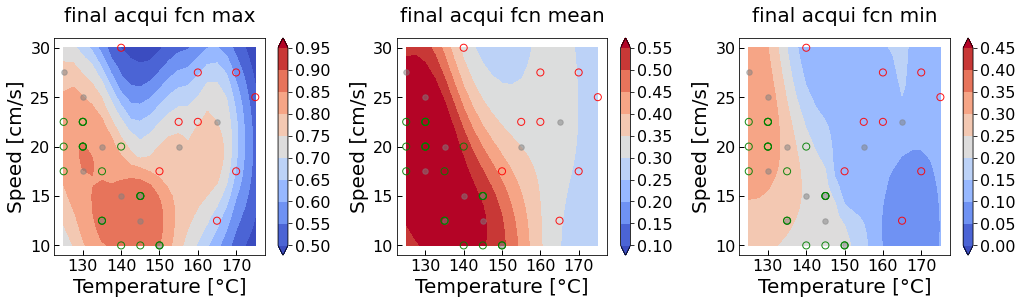

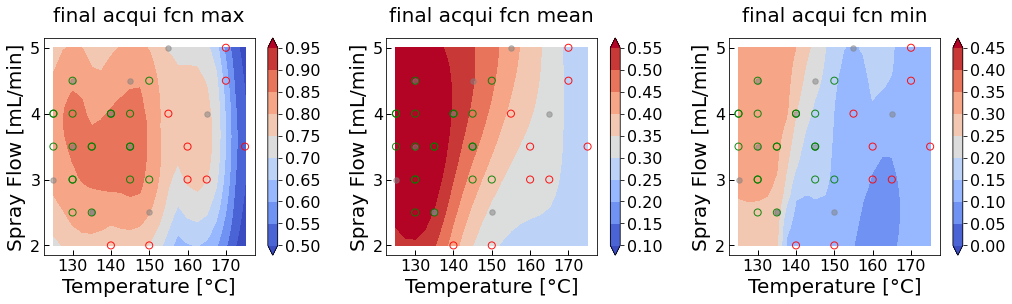

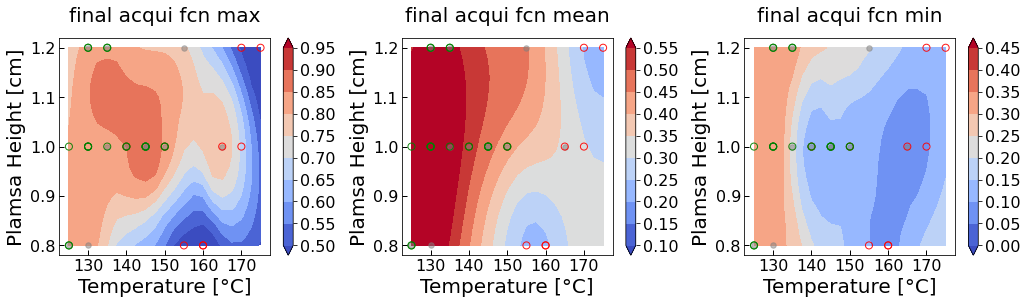

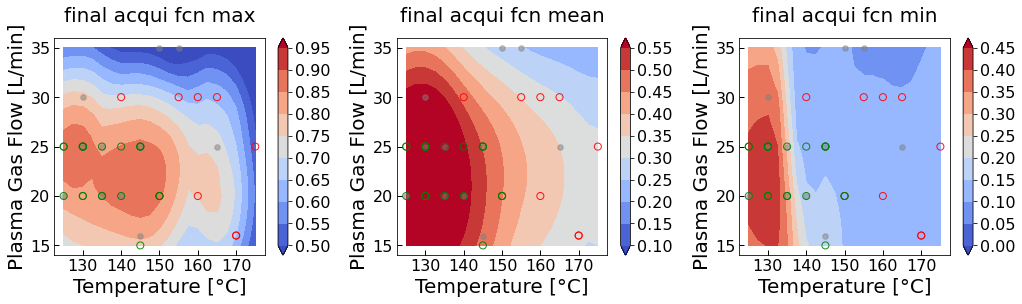

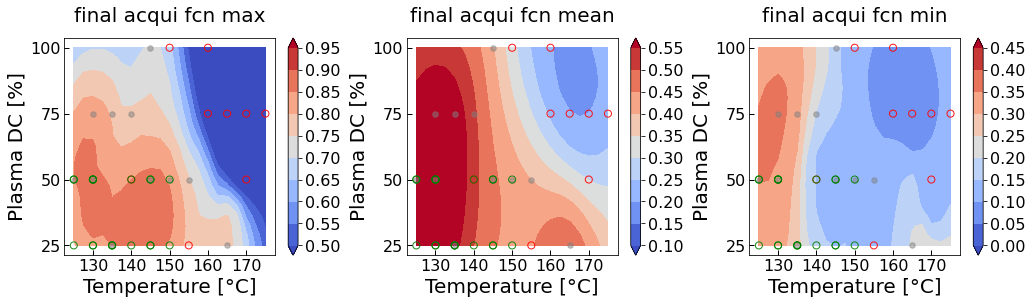

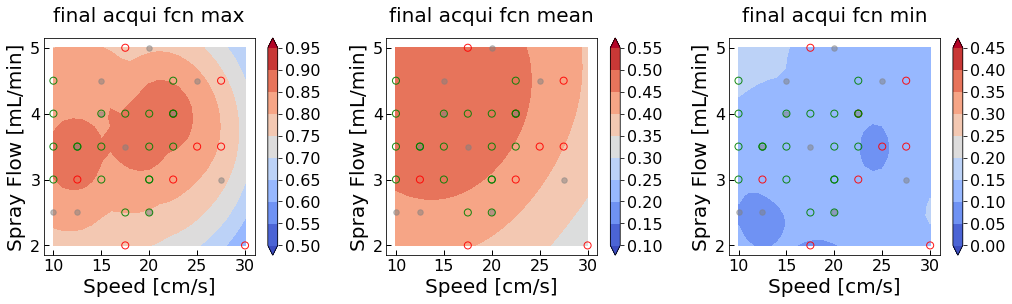

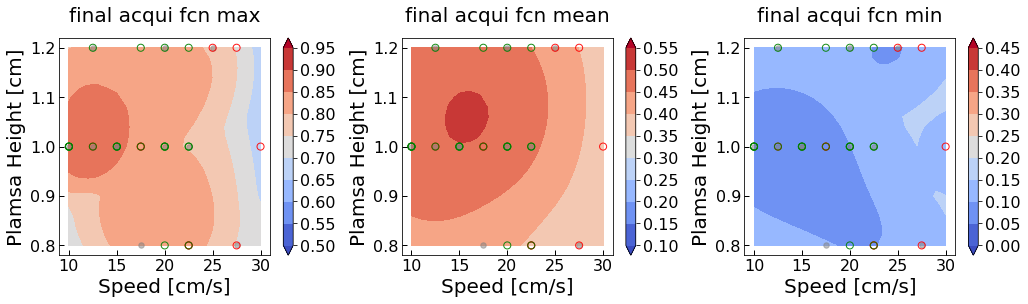

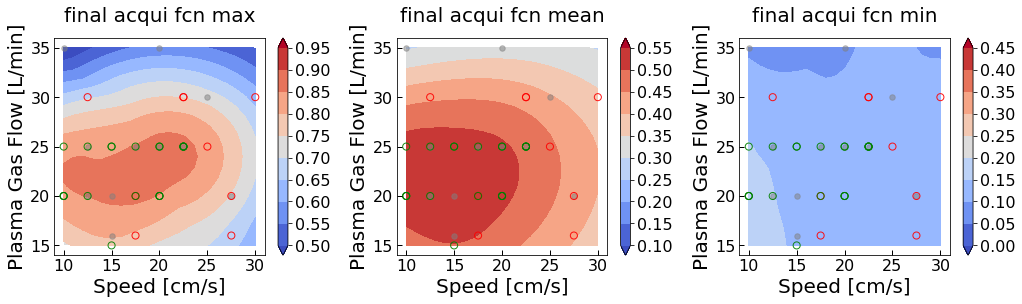

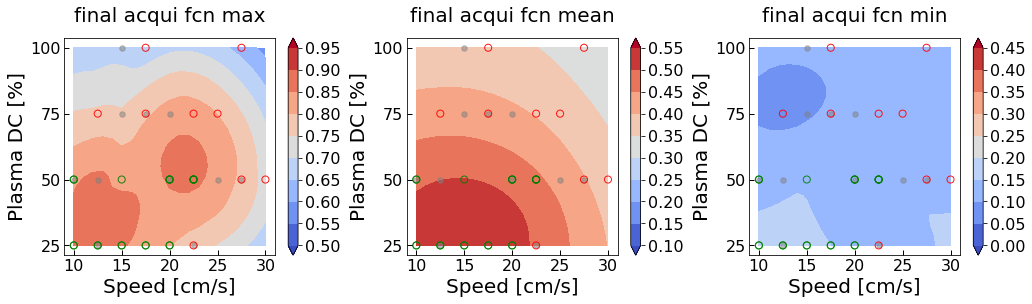

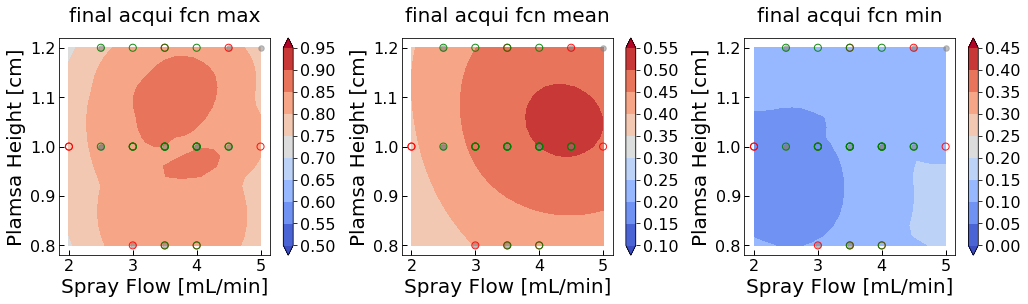

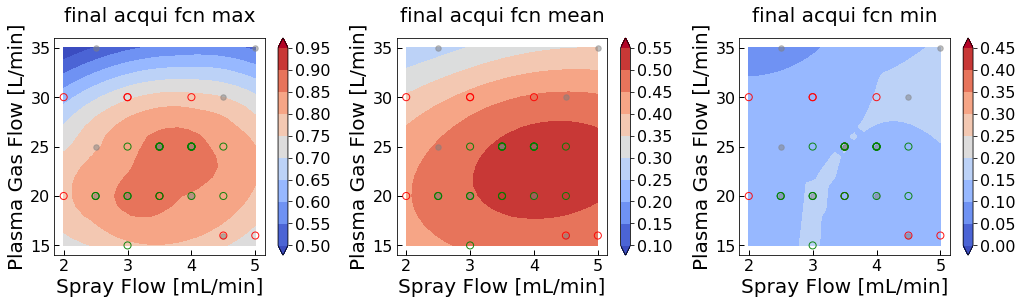

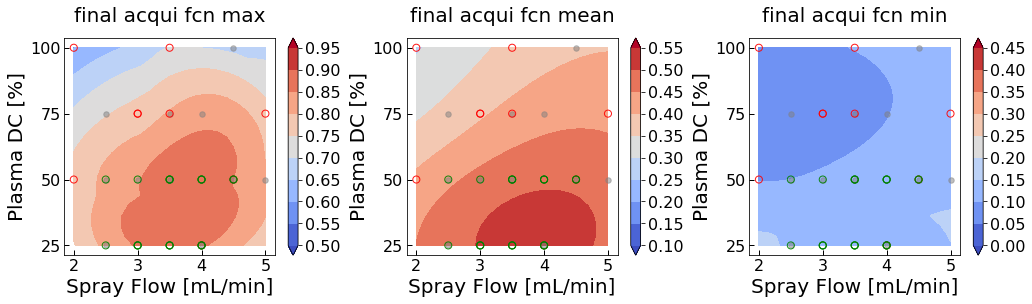

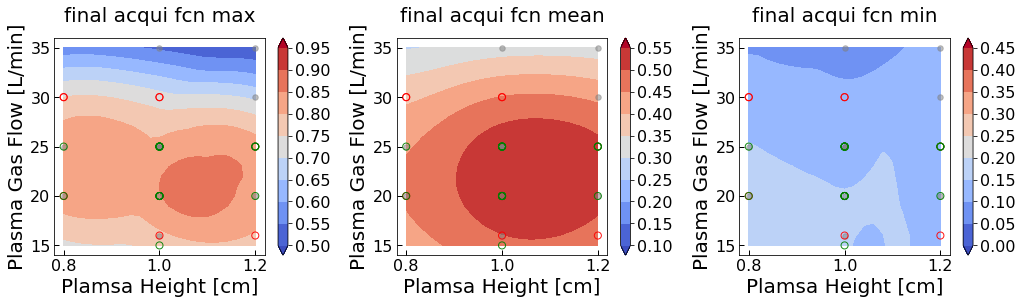

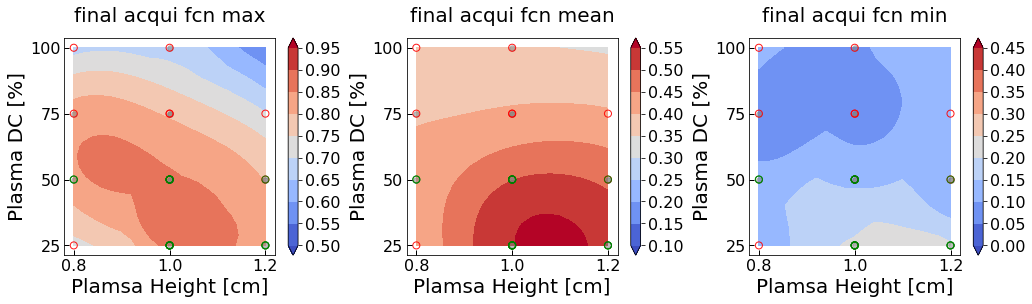

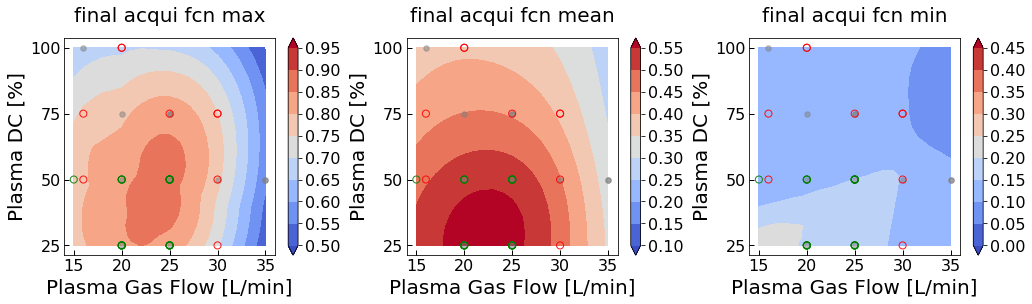

In [ ]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:, 1:-2].columns
for i in range(input_dim):
    for j in range(input_dim - i - 1):
        ind1 = i
        ind2 = j + i + 1
        n_steps = 21
        x1x2y_pred, x1x2y_var = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                yc_pr = f_cons_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)]
                )

        x1c = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

        fontsize = 20
        title_pad = 16

        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        colorbar_offset = [0.5, 0.1, 0.0]
        for ax, y, c_offset in zip(
            axes, [yc_pr_max, yc_pr_mean, yc_pr_min], colorbar_offset
        ):
            c_plt1 = ax.contourf(
                x1c,
                x2c,
                y / 20,
                levels=np.arange(10) * 0.05 + c_offset,
                cmap="coolwarm",
                extend="both",
            )  #
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)
            ax.scatter(
                x_denormalizer(X)[:, ind1],
                x_denormalizer(X)[:, ind2],
                s=30,
                facecolors="gray",
                alpha=0.5,
                edgecolor="gray",
            )
            ax.scatter(
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind1],
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="red",
            )
            ax.scatter(
                x_denormalizer(X_new)[:, ind1],
                x_denormalizer(X_new)[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="green",
            )
            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1c) - np.min(x1c)) * 0.05
            x2_delta = (np.max(x2c) - np.min(x2c)) * 0.05
            ax.set_xlim(np.min(x1c) - x1_delta, np.max(x1c) + x1_delta)
            ax.set_ylim(np.min(x2c) - x2_delta, np.max(x2c) + x2_delta)
            ax.tick_params(
                direction="in",
                length=5,
                width=1,
                labelsize=fontsize * 0.8,
                grid_alpha=0.5,
            )
            if ind1 == 0:  # Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1 == 1:  # Speed
                ax.set_xticks([10, 15, 20, 25, 30])
            if ind1 == 4:  # PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2 == 5:  # PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            # ax.grid(True, linestyle='-.')

        axes[0].set_title("final acqui fcn max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("final acqui fcn mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("final acqui fcn min", pad=title_pad, fontsize=fontsize)
        plt.subplots_adjust(wspace=0.3)
        plt.show()

##### Original Acquisition Function (based on Objective Function only)

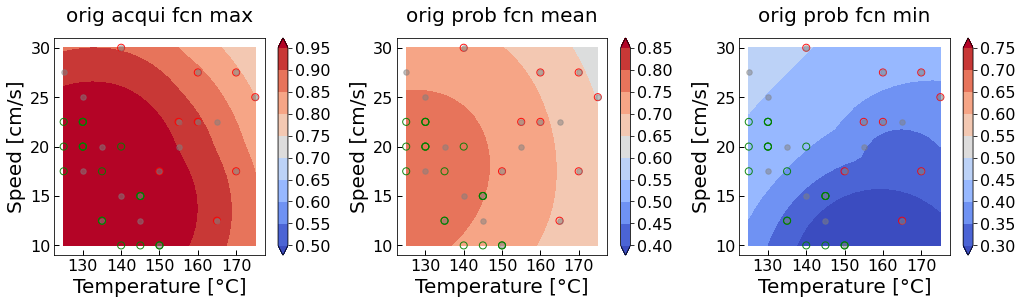

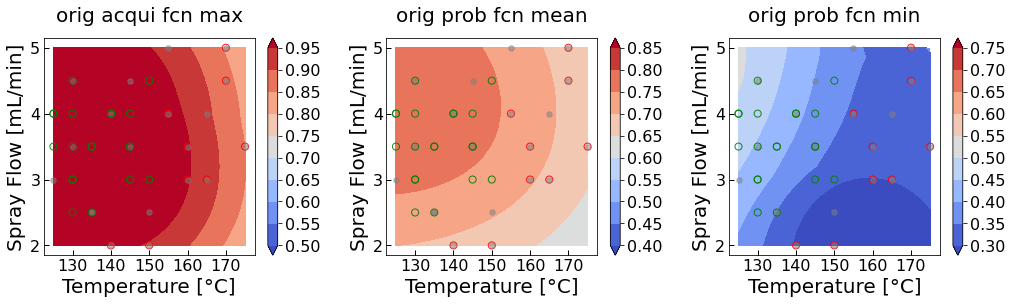

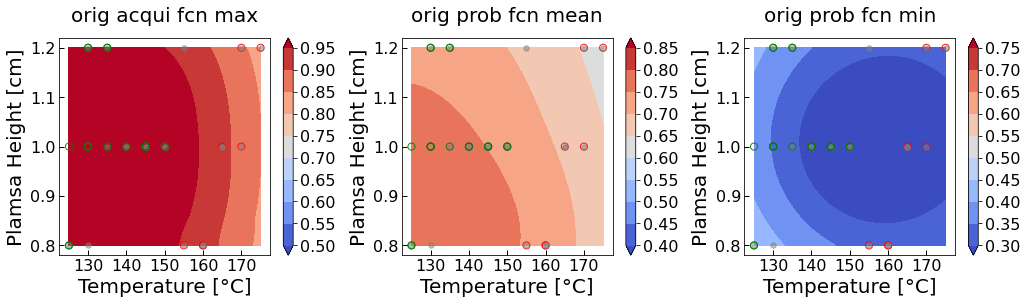

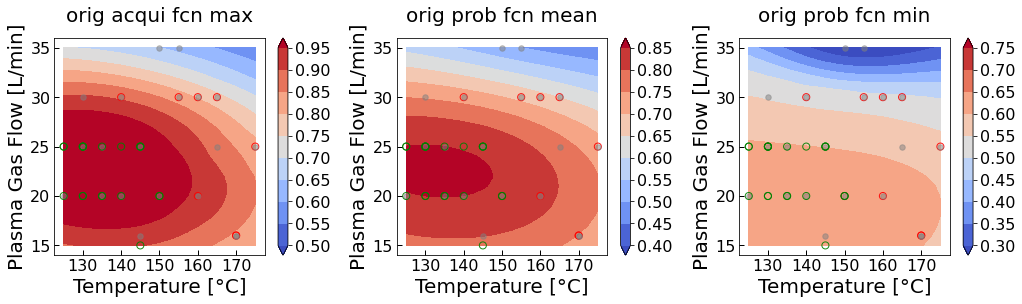

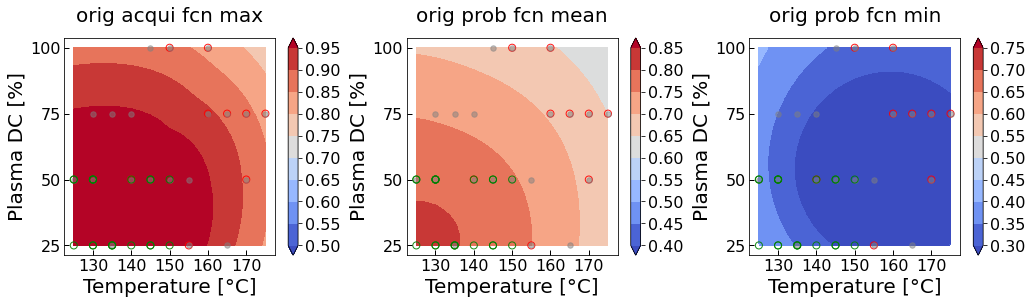

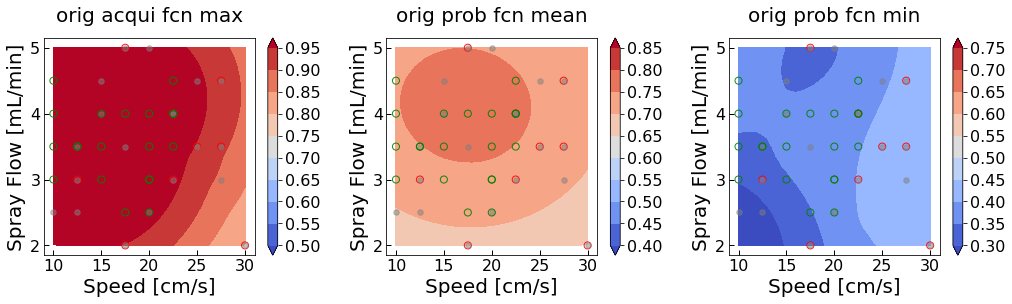

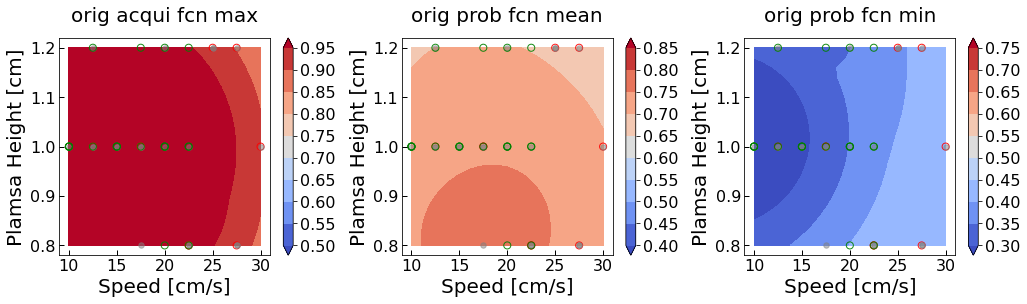

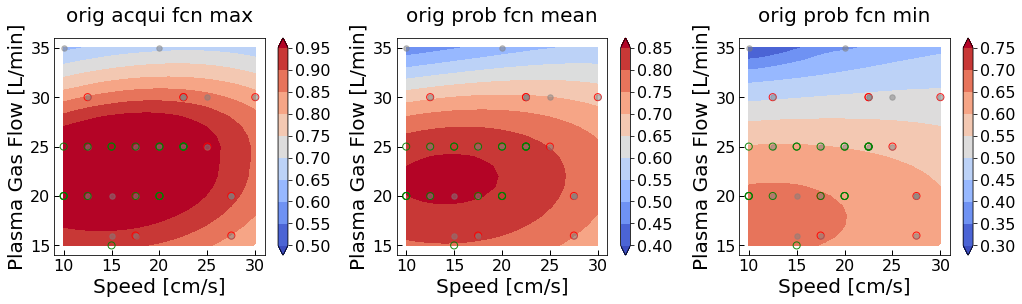

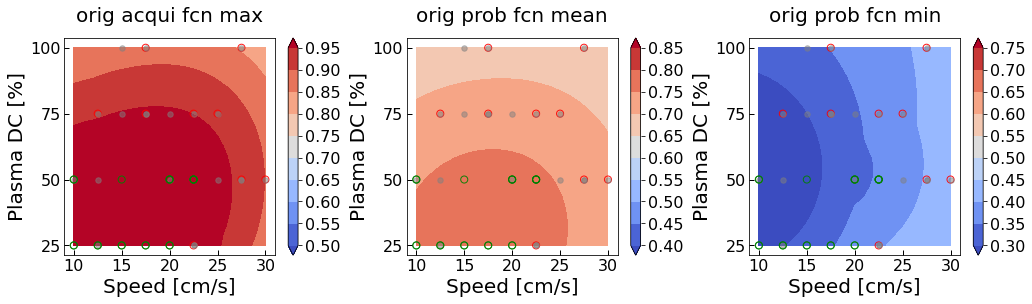

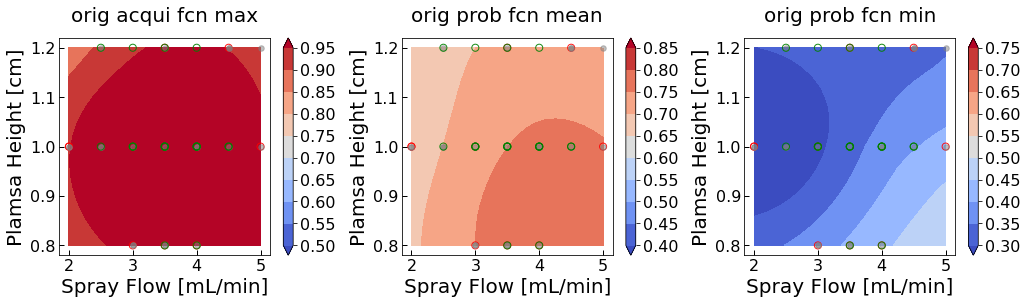

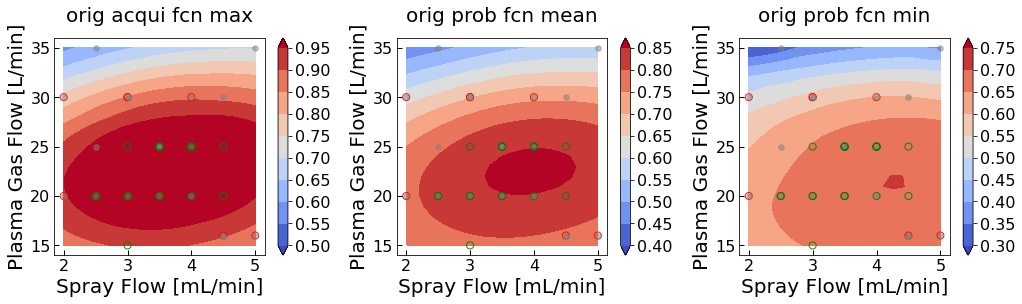

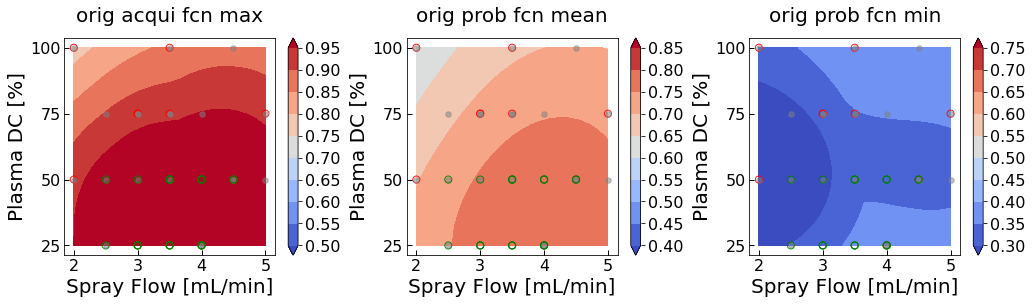

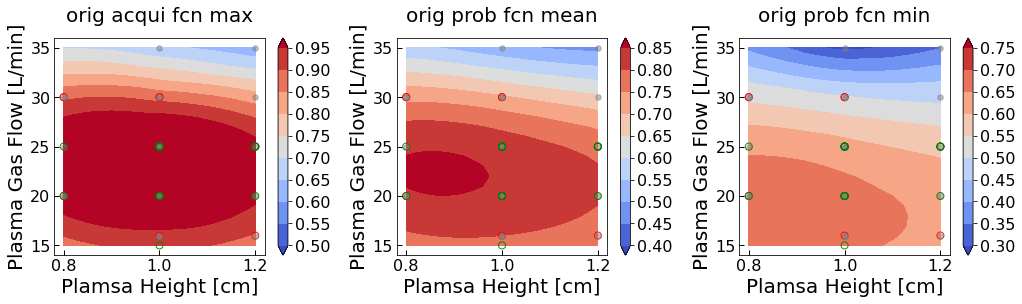

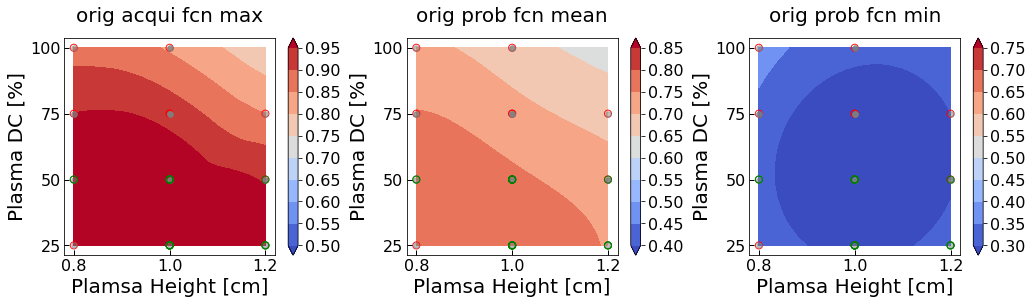

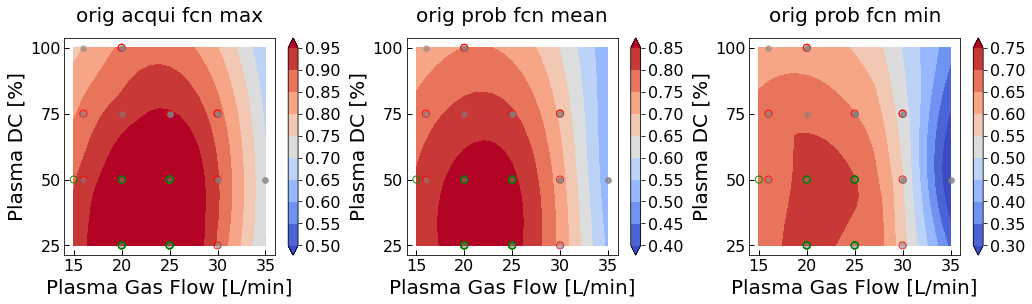

In [ ]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:, 1:-2].columns
for i in range(input_dim):
    for j in range(input_dim - i - 1):
        ind1 = i
        ind2 = j + i + 1
        n_steps = 21
        x1x2y_pred, x1x2y_var = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                yc_pr = f_raw_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)]
                )

        x1c = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

        fontsize = 20
        title_pad = 16

        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        colorbar_offset = [0.5, 0.4, 0.3]
        for ax, y, c_offset in zip(
            axes, [yc_pr_max, yc_pr_mean, yc_pr_min], colorbar_offset
        ):
            c_plt1 = ax.contourf(
                x1c,
                x2c,
                y / 20,
                levels=np.arange(10) * 0.05 + c_offset,
                cmap="coolwarm",
                extend="both",
            )  #
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)
            ax.scatter(
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind1],
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="red",
            )
            ax.scatter(
                x_denormalizer(Xc)[:, ind1],
                x_denormalizer(Xc)[:, ind2],
                s=30,
                facecolors="gray",
                alpha=0.5,
                edgecolor="gray",
            )
            ax.scatter(
                x_denormalizer(X_new)[:, ind1],
                x_denormalizer(X_new)[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="green",
            )

            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1c) - np.min(x1c)) * 0.05
            x2_delta = (np.max(x2c) - np.min(x2c)) * 0.05
            ax.set_xlim(np.min(x1c) - x1_delta, np.max(x1c) + x1_delta)
            ax.set_ylim(np.min(x2c) - x2_delta, np.max(x2c) + x2_delta)
            ax.tick_params(
                direction="in",
                length=5,
                width=1,
                labelsize=fontsize * 0.8,
                grid_alpha=0.5,
            )
            if ind1 == 0:  # Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1 == 1:  # Speed
                ax.set_xticks([10, 15, 20, 25, 30])
            if ind1 == 4:  # PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2 == 5:  # PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            # axes[i].grid(True, linestyle='-.')

        axes[0].set_title("orig acqui fcn max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("orig prob fcn mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("orig prob fcn min", pad=title_pad, fontsize=fontsize)
        plt.subplots_adjust(wspace=0.3)
        plt.show()

##### Probability Function of the Constraint

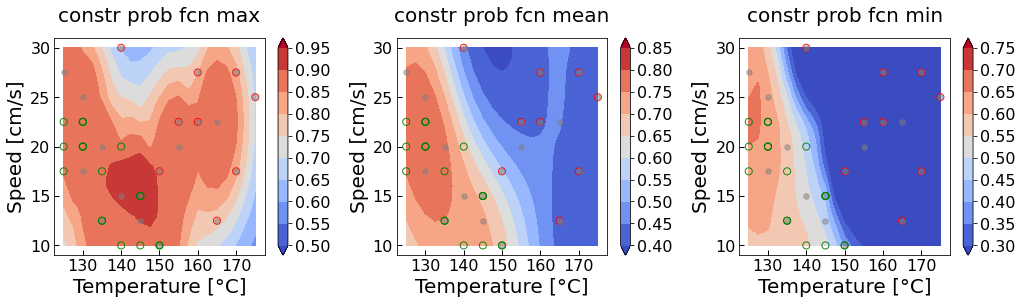

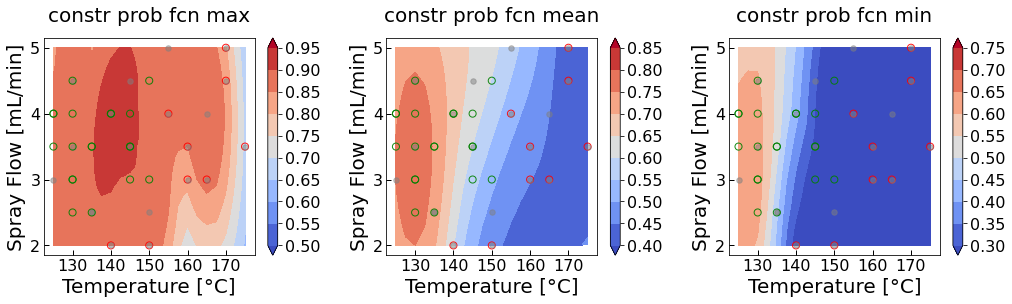

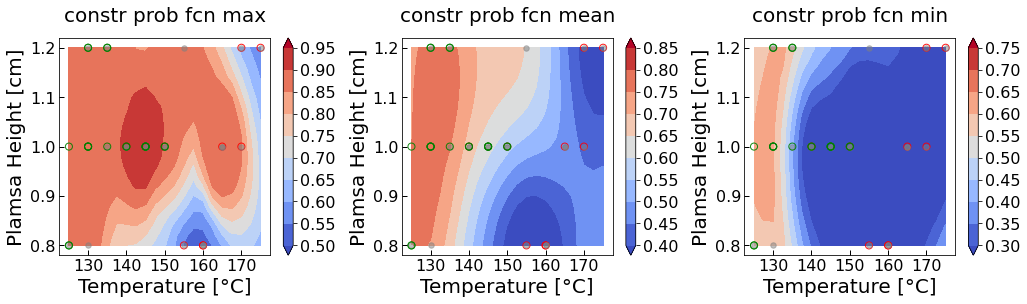

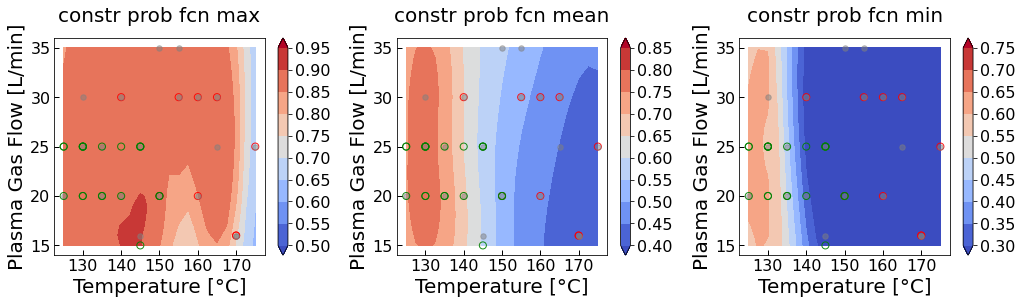

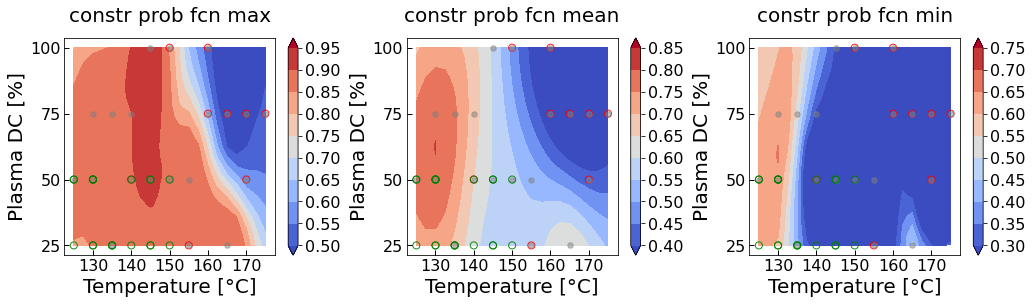

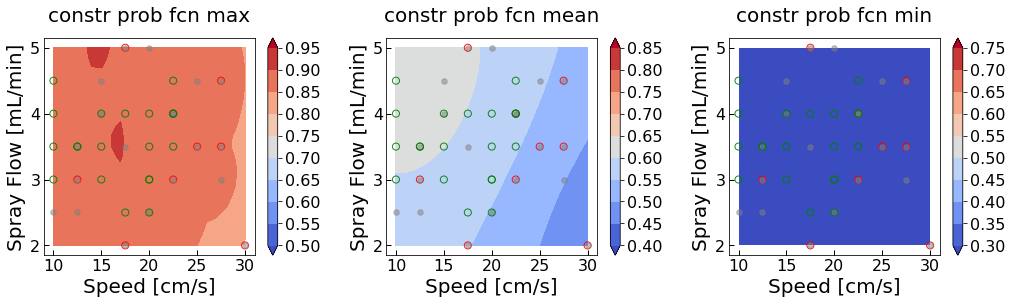

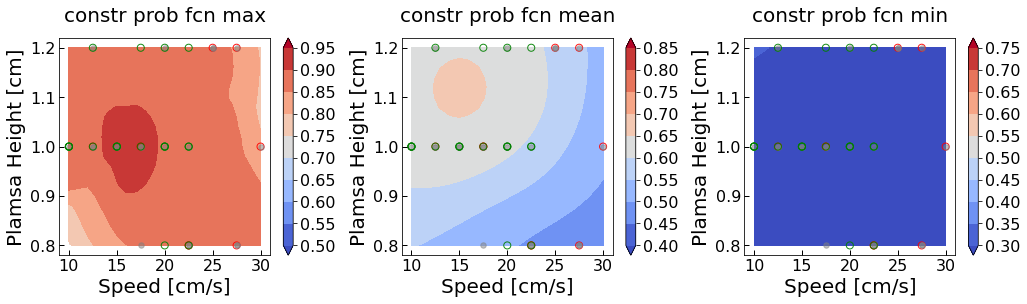

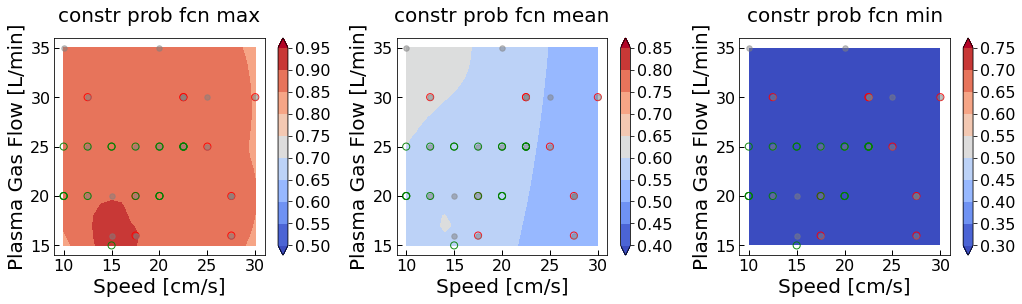

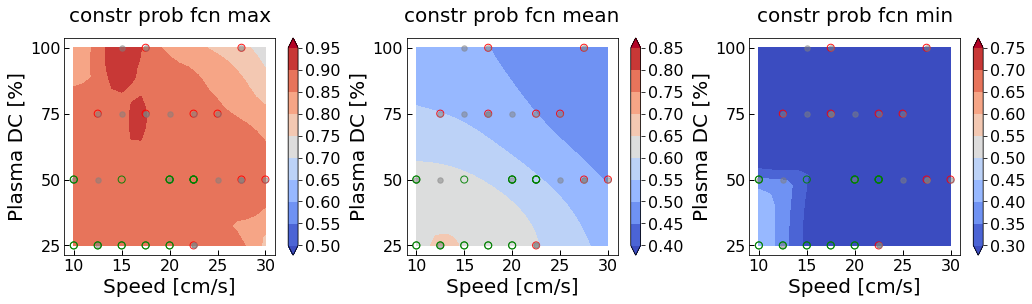

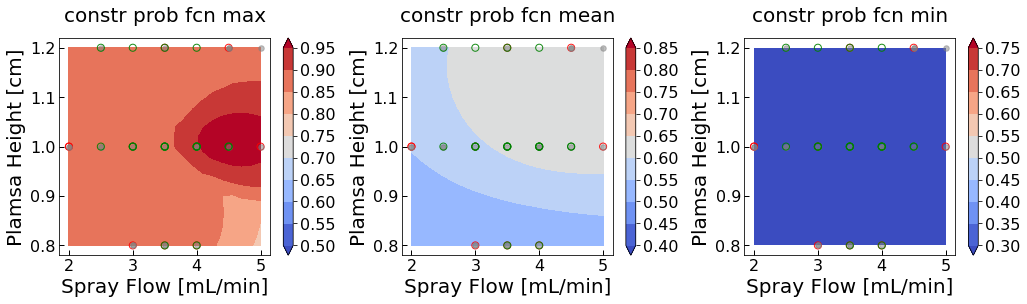

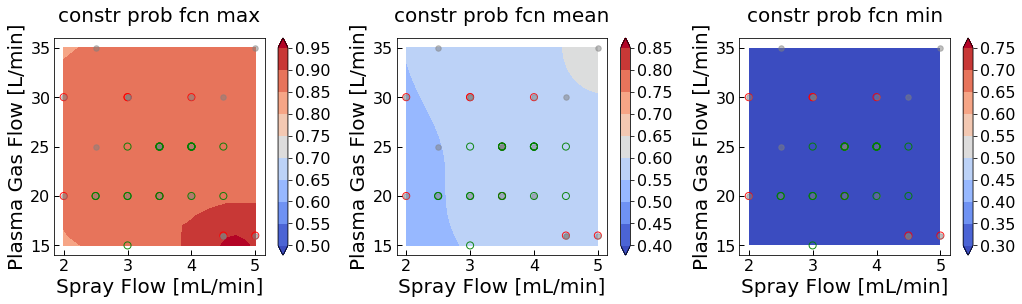

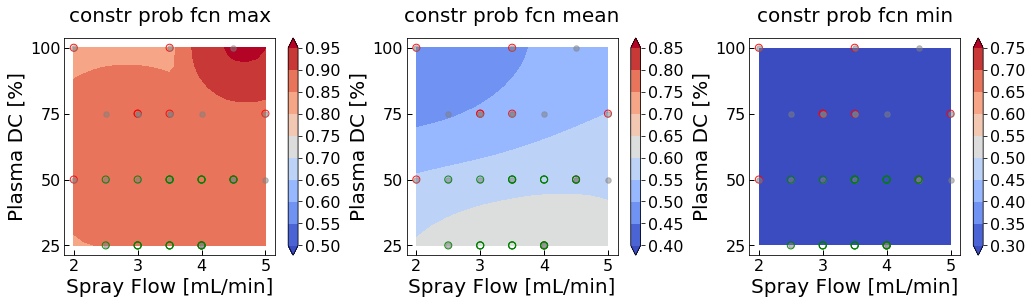

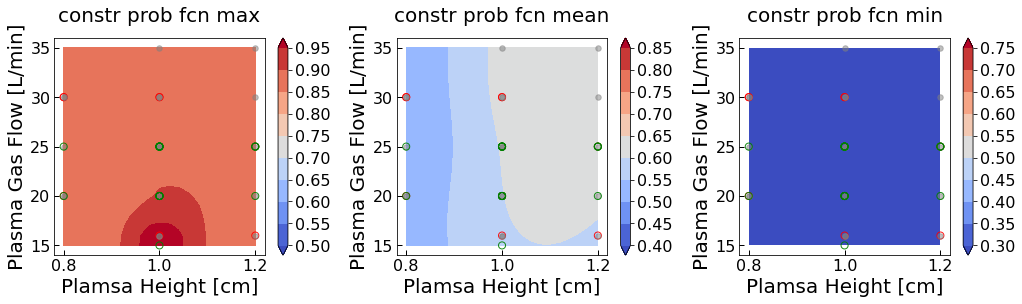

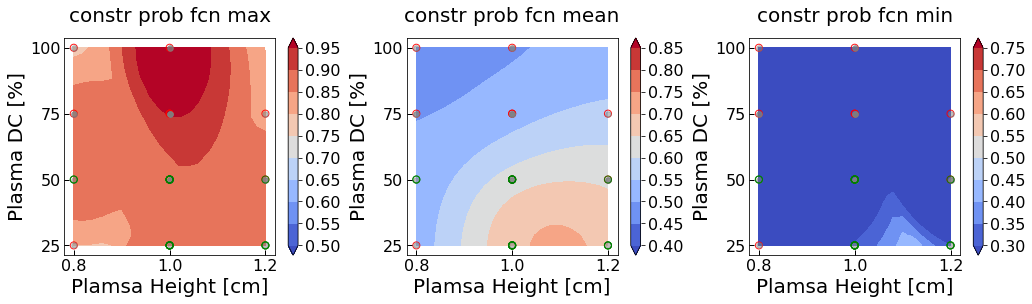

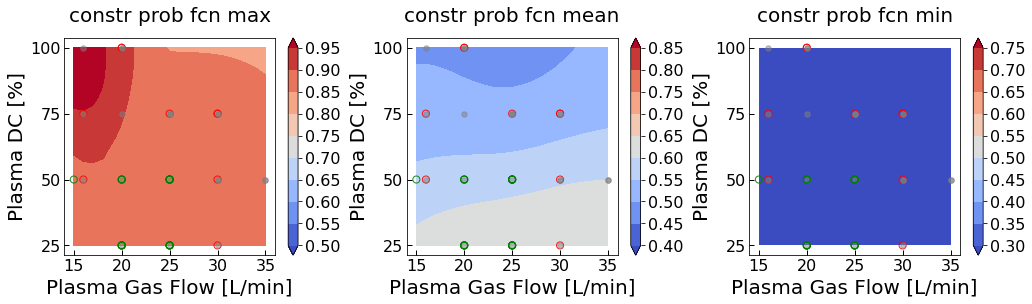

In [ ]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_film.iloc[:, 1:-2].columns
for i in range(input_dim):
    for j in range(input_dim - i - 1):
        ind1 = i
        ind2 = j + i + 1
        n_steps = 21
        x1x2y_pred, x1x2y_var = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                yc_pr = f_cons_pr(x_temp)
                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)]
                )

        x1c = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

        fontsize = 20
        title_pad = 16

        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        colorbar_offset = [0.5, 0.4, 0.3]
        for ax, y, c_offset in zip(
            axes, [yc_pr_max, yc_pr_mean, yc_pr_min], colorbar_offset
        ):
            c_plt1 = ax.contourf(
                x1c,
                x2c,
                y,
                levels=np.arange(10) * 0.05 + c_offset,
                cmap="coolwarm",
                extend="both",
            )  #
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)
            ax.scatter(
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind1],
                x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="red",
            )
            ax.scatter(
                x_denormalizer(Xc)[:, ind1],
                x_denormalizer(Xc)[:, ind2],
                s=30,
                facecolors="gray",
                alpha=0.5,
                edgecolor="gray",
            )
            ax.scatter(
                x_denormalizer(X_new)[:, ind1],
                x_denormalizer(X_new)[:, ind2],
                s=50,
                facecolors="none",
                alpha=0.9,
                edgecolor="green",
            )

            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1c) - np.min(x1c)) * 0.05
            x2_delta = (np.max(x2c) - np.min(x2c)) * 0.05
            ax.set_xlim(np.min(x1c) - x1_delta, np.max(x1c) + x1_delta)
            ax.set_ylim(np.min(x2c) - x2_delta, np.max(x2c) + x2_delta)
            ax.tick_params(
                direction="in",
                length=5,
                width=1,
                labelsize=fontsize * 0.8,
                grid_alpha=0.5,
            )
            if ind1 == 0:  # Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1 == 1:  # Speed
                ax.set_xticks([10, 15, 20, 25, 30])
            if ind1 == 4:  # PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2 == 5:  # PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            # axes[i].grid(True, linestyle='-.')

        axes[0].set_title("constr prob fcn max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("constr prob fcn mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("constr prob fcn min", pad=title_pad, fontsize=fontsize)
        plt.subplots_adjust(wspace=0.3)
        plt.show()